In [1]:
import numpy as np
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.neural_network import MLPRegressor

In [2]:
#loading dataset
house = pd.read_csv('train.csv')
test = pd.read_csv('train.csv')

#we can suppose that the Id column doesn't affect our prevision, so we can save and then drop it from the dataframe
house_id = house['Id']
test_id = test['Id']

house.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
test['SalePrice'] = 0

In [3]:
#costruiamo una funzione che descriva brevemente il dataframe nei suoi attributi 
def rstr(df, pred = None):
    dim = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: x.unique())
    nulls = df.apply(lambda x: x.isnull().sum())
    #percentuale dei nulli sul dataframe
    missing_ratio = (df.isnull().sum()/dim)*100
    skewness = df.skew()
    curtosi = df.kurt()
    print('Data shape: ', df.shape)
    
    if pred is None:
        colonne = ['types', 'counts', 'uniques', 'nulls', 'miss_ratio', 'skew', 'curtosi']
        str = pd.concat([types, counts, uniques, nulls, missing_ratio, skewness, curtosi], axis = 1)
        
    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, uniques, nulls, missing_ratio, skewness, curtosi, corr], axis = 1, sort = False)
        corr_colonna ='corr ' + pred
        colonne = ['types', 'counts', 'uniques', 'nulls', 'miss_ratio', 'skew', 'curtosi', corr_colonna ]
    
    str.columns = colonne
    dtypes = str.types.value_counts()
    print('----------Data types: ', str.types.value_counts())
    print('--------------------')
    return str

In [4]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#details del dataframe
details = rstr(house)

Data shape:  (1460, 80)
----------Data types:  object     43
int64      34
float64     3
Name: types, dtype: int64
--------------------


In [6]:
#details del dataframe correlato a SalePrice
details = rstr(house, 'SalePrice')
#voglio mostrare i valori in colonna in ordine di correlazione con SalePrice
display(details.sort_values(by = 'corr SalePrice', ascending = False), )

Data shape:  (1460, 80)
----------Data types:  object     43
int64      34
float64     3
Name: types, dtype: int64
--------------------


,types,counts,uniques,nulls,miss_ratio,skew,curtosi,corr SalePrice
SalePrice,int64,1460,"[208500, 181500, 223500, 140000, 250000, 14300...",0,0.000000,1.882876,6.536282,1.000000
OverallQual,int64,1460,"[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]",0,0.000000,0.216944,0.096293,0.790982
GrLivArea,int64,1460,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209...",0,0.000000,1.366560,4.895121,0.708624
GarageCars,int64,1460,"[2, 3, 1, 0, 4]",0,0.000000,-0.342549,0.220998,0.640409
GarageArea,int64,1460,"[548, 460, 608, 642, 836, 480, 636, 484, 468, ...",0,0.000000,0.179981,0.917067,0.623431
TotalBsmtSF,int64,1460,"[856, 1262, 920, 756, 1145, 796, 1686, 1107, 9...",0,0.000000,1.524255,13.250483,0.613581
1stFlrSF,int64,1460,"[856, 1262, 920, 961, 1145, 796, 1694, 1107, 1...",0,0.000000,1.376757,5.745841,0.605852
FullBath,int64,1460,"[2, 1, 3, 0]",0,0.000000,0.036562,-0.857043,0.560664
TotRmsAbvGrd,int64,1460,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]",0,0.000000,0.676341,0.880762,0.533723
YearBuilt,int64,1460,"[2003, 1976, 2001, 1915, 2000, 1993, 2004, 197...",0,0.000000,-0.613461,-0.439552,0.522897


In [7]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

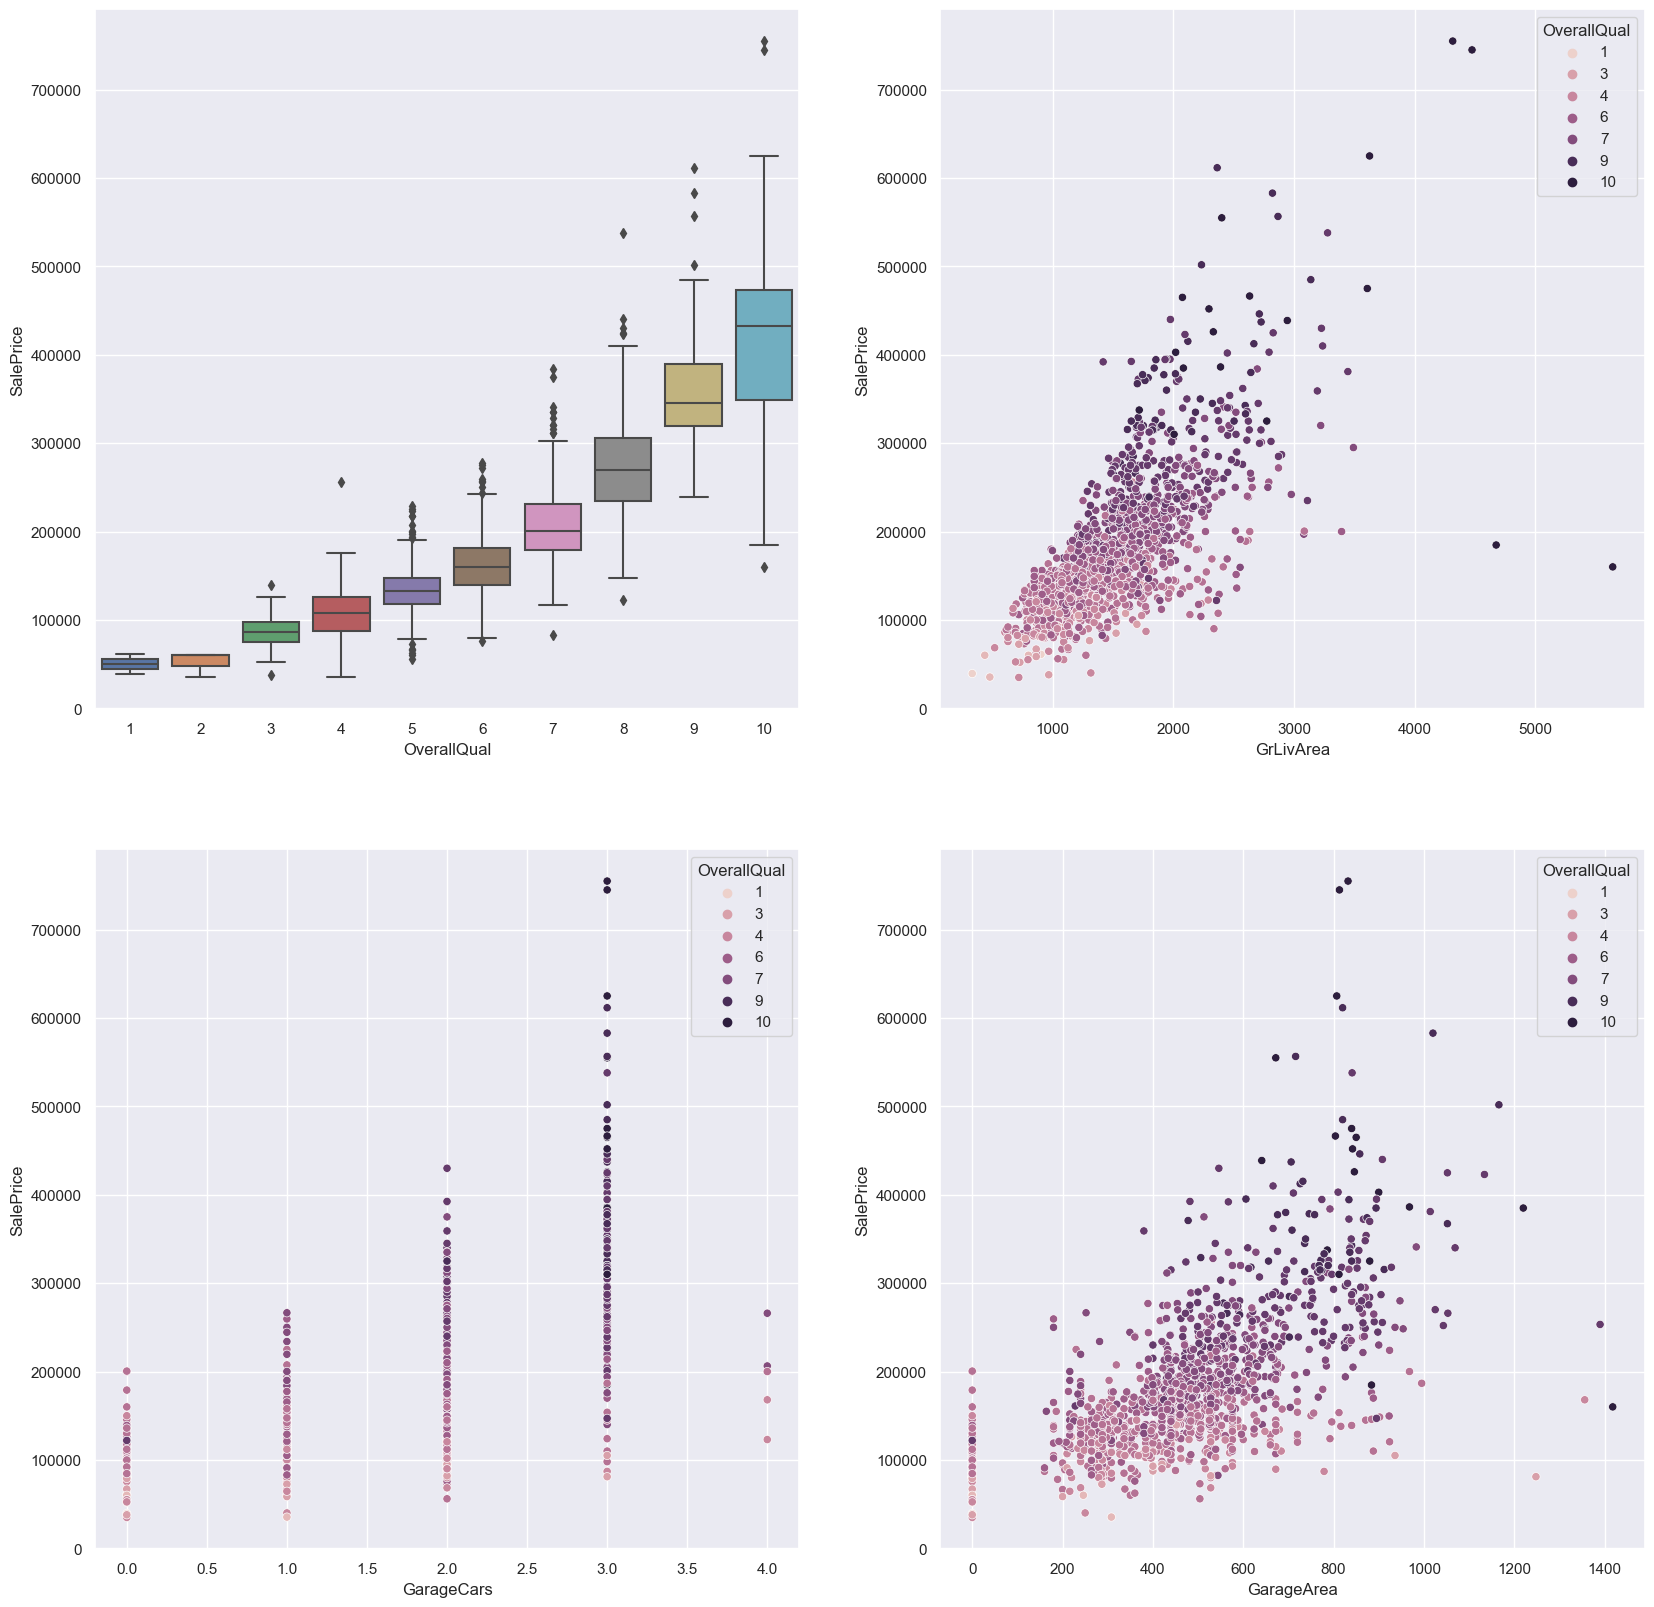

In [8]:
#Valutando le correlazioni, notiamo come siano 26 i features a correlazione positiva
#plot delle prime quattro features maggiormente correlate: non ci stupisce che le condizioni 
#generali della casa (overalconditions) siano maggiormente correlate col prezzo di vendita


fig = plt.figure(figsize = (20, 20))
sns.set(font_scale = 1)

#OverallQual vs SalePrice (coorelated 0.790982)
fig1 = fig.add_subplot(221);
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = house[['SalePrice', 'OverallQual']])
#GrLivArea vs SalePrice (coorelated 0.708624)
fig2 = fig.add_subplot(222);
sns.scatterplot(x = house.GrLivArea, y = house.SalePrice, hue = house.OverallQual)
#GarageCars vs SalePrice (correlated 0.640409)
fig3 = fig.add_subplot(223);
sns.scatterplot(x = house.GarageCars, y = house.SalePrice, hue = house.OverallQual)
#GarageArea vs SalePrice (correlated 0.623431)
fig4 = fig.add_subplot(224);
sns.scatterplot(x = house.GarageArea, y = house.SalePrice, hue = house.OverallQual)

plt.show()


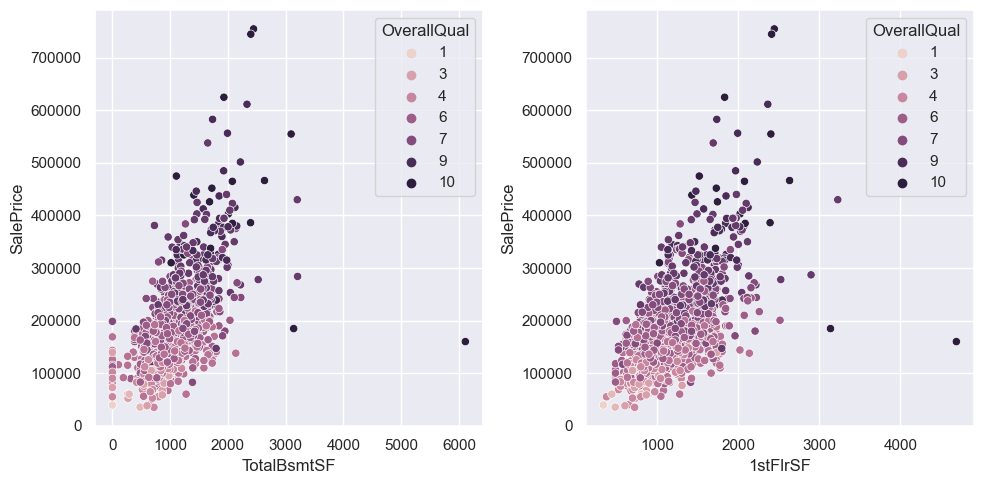

In [9]:
#now we can even plot high-skewed features, with high correlation with saleprice
#and a heavy-tailed distribution (see kurtosis values): TotalBsmtSF 0.613581 and 1stFlrSF 0.605852

fig5 = plt.figure(figsize=(10, 5))
#TotalBsmtSF vs SalePrice (correlated 0.613581)
fig6 = fig5.add_subplot(121);
sns.scatterplot(x = house.TotalBsmtSF, y = house.SalePrice, hue = house.OverallQual)
#TotalBsmtSF vs 1stFlrSF (correlated 0.605852)
fig7 = fig5.add_subplot(122);
sns.scatterplot(x = house['1stFlrSF'], y = house.SalePrice, hue = house.OverallQual)
plt.tight_layout(); plt.show()


In [10]:
#rimuoviamo gli outlier (restringiamo di fatto il dataset ai valori maggiormente concentrati)
house = house.drop(house[(house.GrLivArea > 4000)&(house.SalePrice < 300000)].index)
house = house.drop(house[(house.GarageArea > 1200)&(house.SalePrice < 300000)].index)
house = house.drop(house[(house.TotalBsmtSF > 4000)&(house.SalePrice < 300000)].index)
house = house.drop(house[(house['1stFlrSF'] > 4000)&(house.SalePrice < 300000)].index)


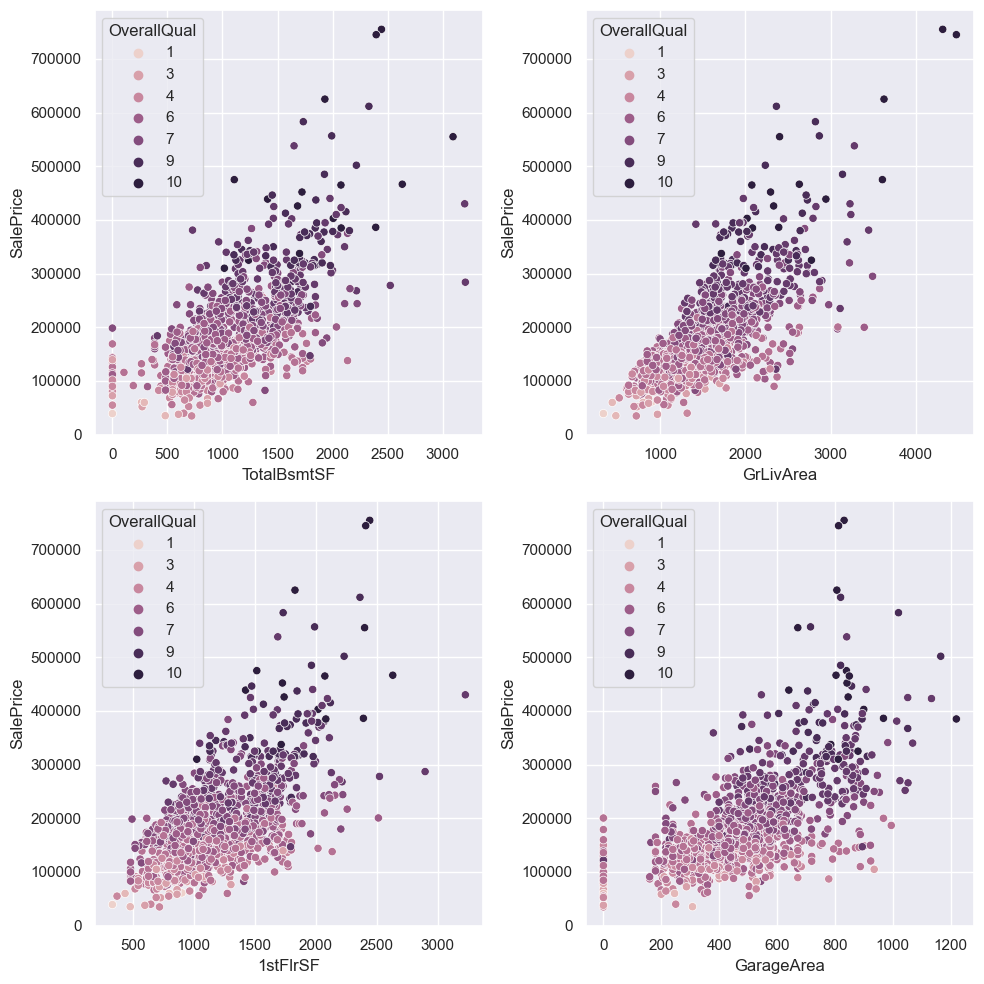

In [11]:
#replot senza gli outliers
fig = plt.figure(figsize = (10, 10))
sns.set(font_scale = 1)

fig1 = fig.add_subplot(221);
sns.scatterplot(x = house.TotalBsmtSF, y = house.SalePrice, hue = house.OverallQual)

fig2 = fig.add_subplot(222);
sns.scatterplot(x = house.GrLivArea, y = house.SalePrice, hue = house.OverallQual)

fig3 = fig.add_subplot(223);
sns.scatterplot(x = house['1stFlrSF'], y = house.SalePrice, hue = house.OverallQual)

fig4 = fig.add_subplot(224);
sns.scatterplot(x = house.GarageArea, y = house.SalePrice, hue = house.OverallQual)
plt.tight_layout(); plt.show()


In [12]:
#ci viene il dubbio che combinando le correlazioni delle features che riguardano il garage
#con il numero di auto di capienza, queste possano aumentare. definiamo allora dei nuovi df
#tali che

house_garage = house[['SalePrice', 'GarageCars', 'GarageArea']]
house_garage['GArea_by_Car'] = house.GarageArea/house.GarageCars
house_garage['GArea_times_Car'] = house.GarageArea*house.GarageCars

details = rstr(house_garage, 'SalePrice')
display(details.sort_values(by = 'corr SalePrice', ascending = False), )


Data shape:  (1455, 5)
----------Data types:  int64      4
float64    1
Name: types, dtype: int64
--------------------


,types,counts,uniques,nulls,miss_ratio,skew,curtosi,corr SalePrice
SalePrice,int64,1455,"[208500, 181500, 223500, 140000, 250000, 14300...",0,0.00000,1.883885,6.530542,1.000000
GArea_times_Car,int64,1455,"[1096, 920, 1216, 1926, 2508, 960, 1272, 968, ...",0,0.00000,1.077869,1.189616,0.703703
GarageCars,int64,1455,"[2, 3, 1, 0, 4]",0,0.00000,-0.359031,0.207334,0.645516
GarageArea,int64,1455,"[548, 460, 608, 642, 836, 480, 636, 484, 468, ...",0,0.00000,0.018023,0.411623,0.641664
GArea_by_Car,float64,1374,"[274.0, 230.0, 304.0, 214.0, 278.6666666666667...",81,5.56701,2.828027,18.488690,-0.012187


In [13]:
#notiamo quindi che la correlazione di GArea_times_Car è maggiore rispetto alle due features separate
#ripetiamo lo stesso ragionamento con le features riferite al bagno
house_bath =  house[['SalePrice', 'FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath']]
house_bath['FullBath_times_Bsmt'] = house_bath.FullBath*house_bath.BsmtFullBath
house_bath['FullBath_by_Bsmt'] = house_bath.FullBath/house_bath.BsmtFullBath
house_bath['HalfBath_times_Bsmt'] = house_bath.HalfBath*house_bath.BsmtHalfBath
house_bath['HalfBath_by_Bsmt'] = house_bath.HalfBath/house_bath.BsmtHalfBath
details = rstr(house_bath, 'SalePrice')
display(details.sort_values(by = 'corr SalePrice', ascending = False), )


Data shape:  (1455, 9)
----------Data types:  int64      7
float64    2
Name: types, dtype: int64
--------------------


,types,counts,uniques,nulls,miss_ratio,skew,curtosi,corr SalePrice
SalePrice,int64,1455,"[208500, 181500, 223500, 140000, 250000, 14300...",0,0.000000,1.883885,6.530542,1.000000
FullBath_by_Bsmt,float64,1454,"[2.0, inf, 1.0, 3.0, 0.0, 0.5, nan]",1,0.068729,NaN,NaN,0.603978
FullBath,int64,1455,"[2, 1, 3, 0]",0,0.000000,0.029872,-0.868248,0.561666
FullBath_times_Bsmt,int64,1455,"[2, 0, 1, 3, 4, 9]",0,0.000000,1.467040,5.066105,0.379932
HalfBath,int64,1455,"[1, 0, 2]",0,0.000000,0.679947,-1.069607,0.283578
BsmtFullBath,int64,1455,"[1, 0, 2, 3]",0,0.000000,0.590046,-0.863557,0.228782
HalfBath_by_Bsmt,float64,602,"[inf, 0.0, nan, 1.0, 2.0]",853,58.625430,NaN,NaN,0.195591
HalfBath_times_Bsmt,int64,1455,"[0, 1, 2, 4]",0,0.000000,12.299567,201.990120,0.029123
BsmtHalfBath,int64,1455,"[0, 1, 2]",0,0.000000,4.095176,16.324530,-0.016981


In [14]:
#potremmo fermarci qui e passare al cut degli outliers, però notiamo che la correlazione di halfbath 
#è esattamente la metà di un fullbath. Inoltre anche in questo caso non sappiamo se droppare via BsmtHalfBath, 
#che ha correlazione addirittura negativa. 
bath =  house[['SalePrice', 'FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath']]
bath['Total-baths'] = bath.FullBath + (0.5*bath.HalfBath)
bath['Total_bsmts'] = bath.BsmtFullBath + (0.5*bath.BsmtHalfBath)
bath['Tot_baths_bsmt'] = bath.FullBath + (0.5*bath.HalfBath) + bath.BsmtFullBath + (0.5*bath.BsmtHalfBath)
details = rstr(bath, 'SalePrice')
display(details.sort_values(by = 'corr SalePrice', ascending = False), )


Data shape:  (1455, 8)
----------Data types:  int64      5
float64    3
Name: types, dtype: int64
--------------------


,types,counts,uniques,nulls,miss_ratio,skew,curtosi,corr SalePrice
SalePrice,int64,1455,"[208500, 181500, 223500, 140000, 250000, 14300...",0,0.0,1.883885,6.530542,1.000000
Tot_baths_bsmt,float64,1455,"[3.5, 2.5, 2.0, 3.0, 4.0, 1.0, 1.5, 6.0, 4.5, ...",0,0.0,0.246647,-0.167873,0.635397
Total-baths,float64,1455,"[2.5, 2.0, 1.0, 1.5, 3.0, 3.5, 0.5, 0.0]",0,0.0,0.123868,-0.881474,0.599406
FullBath,int64,1455,"[2, 1, 3, 0]",0,0.0,0.029872,-0.868248,0.561666
HalfBath,int64,1455,"[1, 0, 2]",0,0.0,0.679947,-1.069607,0.283578
BsmtFullBath,int64,1455,"[1, 0, 2, 3]",0,0.0,0.590046,-0.863557,0.228782
Total_bsmts,float64,1455,"[1.0, 0.5, 0.0, 2.0, 1.5, 3.0]",0,0.0,0.513184,-0.843951,0.226562
BsmtHalfBath,int64,1455,"[0, 1, 2]",0,0.0,4.095176,16.324530,-0.016981


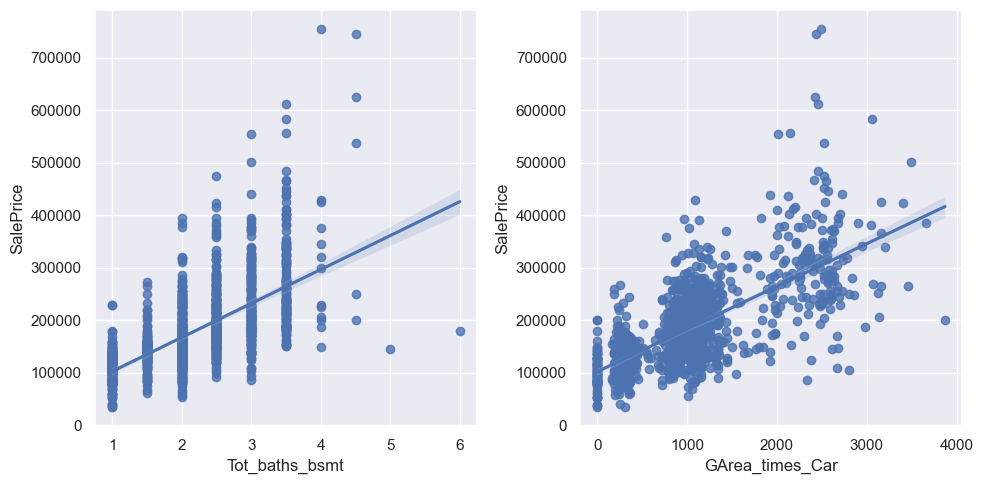

Corr with outliers GArea_times_Car/SalePrice: 0.7037031304852853
Corr with outliers Tot_baths_bsmt/SalePrice: 0.6353971071520166


In [15]:
fig = plt.figure(figsize=(10, 5))
#Tot_baths_bsmt vs SalePrice (correlated 0.635397)
fig1 = fig.add_subplot(121);
sns.regplot(x = bath.Tot_baths_bsmt, y = bath.SalePrice, data = bath)
#GArea_times_Car vs SalePrice (correlated 0.70)
fig2 = fig.add_subplot(122);
sns.regplot(x = house_garage.GArea_times_Car, y = house_garage.SalePrice, data = house_garage)
plt.tight_layout(); plt.show()
print('Corr with outliers GArea_times_Car/SalePrice:', house_garage.GArea_times_Car.corr(house_garage['SalePrice']))
print('Corr with outliers Tot_baths_bsmt/SalePrice:', bath.Tot_baths_bsmt.corr(bath['SalePrice']))


Outliers GArea_times_Car: 1
Outliers Tot_baths_bsmt: 2


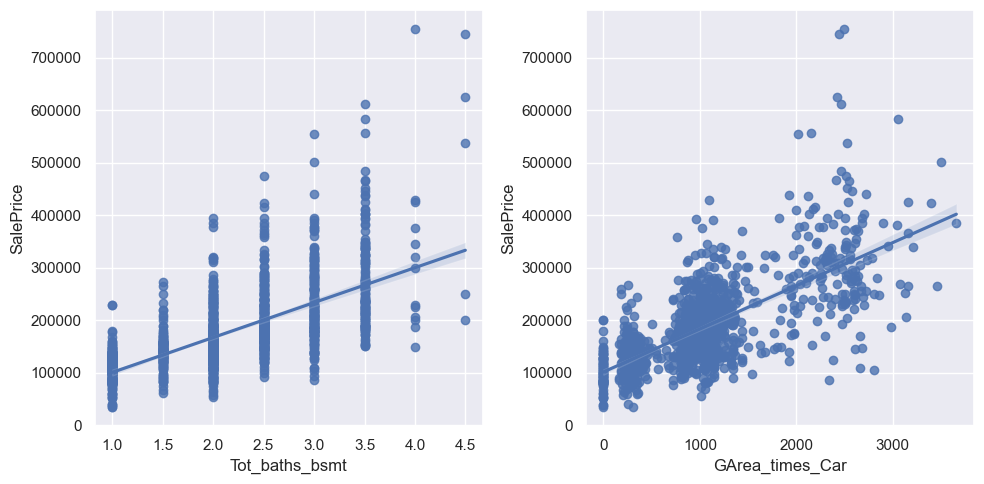

Corr without outliers GArea_times_Car/SalePrice: 0.7073585296408306
Corr without outliers Tot_baths_bsmt/SalePrice: 0.6447187511826067


In [16]:
#house = house.drop(house[(house.GrLivArea > 4000)&(house.SalePrice < 300000)].index)
print('Outliers GArea_times_Car:',(house_garage.GArea_times_Car>=3700).sum())
print('Outliers Tot_baths_bsmt:', (bath.Tot_baths_bsmt >= 5).sum())
bath_noout = bath.loc[bath.Tot_baths_bsmt<5]
house_garage_noout = house_garage.loc[house_garage.GArea_times_Car < 3700]

fig = plt.figure(figsize=(10, 5))
fig1 = fig.add_subplot(121);
sns.regplot(x = bath_noout.Tot_baths_bsmt, y = bath_noout.SalePrice, data = bath_noout)

fig2 = fig.add_subplot(122);
sns.regplot(x = house_garage_noout.GArea_times_Car, y = house_garage_noout.SalePrice, data = house_garage_noout)
plt.tight_layout(); plt.show()

print('Corr without outliers GArea_times_Car/SalePrice:', house_garage_noout.GArea_times_Car.corr(house_garage_noout['SalePrice']))
print('Corr without outliers Tot_baths_bsmt/SalePrice:', bath_noout.Tot_baths_bsmt.corr(bath_noout['SalePrice']))


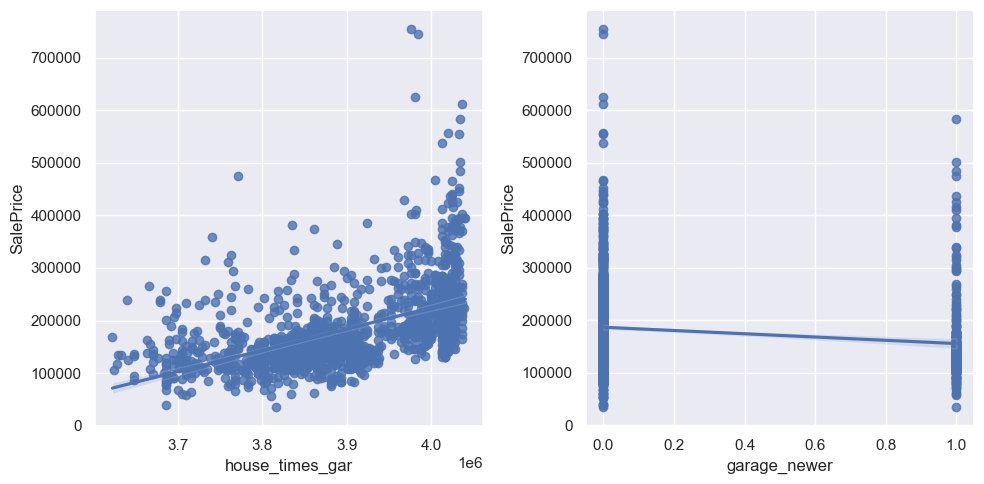

Corr with outliers house_times_gar/SalePrice: 0.5229461258191319
Corr with outliers garage_newer/SalePrice: -0.15381806023978617


In [17]:
#valutiamo ora l'anno di realizzazione del garage con l'anno di costruzione della casa. 
#ipotizziamo infatti che una casa con un garage nuovo possa avere maggiore appeal rispetto a una casa con un garage più datato
gar_year = house[['SalePrice', 'YearBuilt', 'GarageYrBlt']]
gar_year['house_times_gar'] = house.YearBuilt * house.GarageYrBlt 
gar_year['garage_newer'] = house.YearBuilt < house.GarageYrBlt

fig = plt.figure(figsize=(10, 5))
#house_times_gar vs SalePrice 
fig1 = fig.add_subplot(121);
sns.regplot(x = gar_year.house_times_gar, y = gar_year.SalePrice, data = gar_year)
#garage_newer vs SalePrice
fig2 = fig.add_subplot(122);
sns.regplot(x = gar_year.garage_newer, y = gar_year.SalePrice, data = gar_year)
plt.tight_layout(); plt.show()
print('Corr with outliers house_times_gar/SalePrice:', gar_year.house_times_gar.corr(gar_year['SalePrice']))
print('Corr with outliers garage_newer/SalePrice:', gar_year.garage_newer.corr(gar_year['SalePrice']))


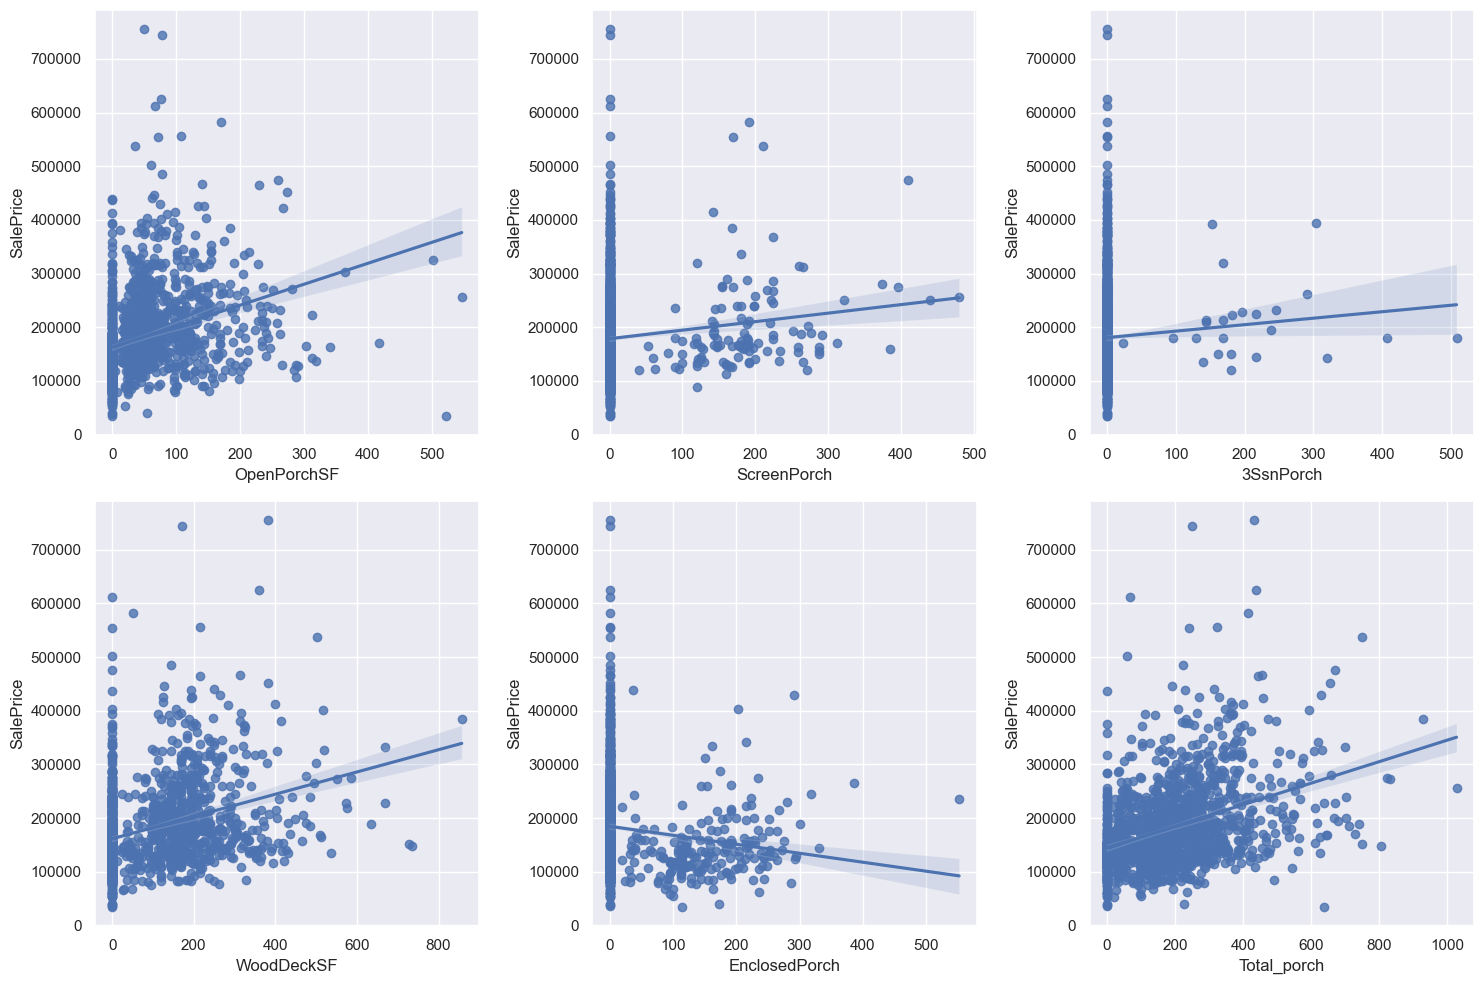

Corr with outliers Total_porch/SalePrice: 0.39344333887763455
Variance of Total_porch: 24354.701482815446


In [18]:
#procediamo con le features legate al porch e alla veranda (portico):
# OpenPorchSF 0.315856
# ScreenPorch 0.111447
# 3SsnPorch 0.044584
# EnclosedPorch -0.128578
# WoodDeckSF 0.324413
#replot senza gli outliers
fig = plt.figure(figsize = (15, 10))
sns.set(font_scale = 1)
porch = house[['SalePrice', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'WoodDeckSF', 'ScreenPorch']]
porch['Total_porch'] = porch.OpenPorchSF + porch['3SsnPorch'] + porch.EnclosedPorch + porch.WoodDeckSF + porch.ScreenPorch

fig1 = fig.add_subplot(231);
sns.regplot(x = house.OpenPorchSF, y = porch.SalePrice, data = porch)

fig2 = fig.add_subplot(232);
sns.regplot(x = house.ScreenPorch, y = porch.SalePrice, data = porch)

fig3 = fig.add_subplot(233);
sns.regplot(x = house['3SsnPorch'], y = porch.SalePrice, data = porch)

fig4 = fig.add_subplot(234);
sns.regplot(x = house.WoodDeckSF, y = porch.SalePrice, data = porch)

fig5 = fig.add_subplot(235);
sns.regplot(x = house.EnclosedPorch, y = porch.SalePrice, data = porch)


fig6 = fig.add_subplot(236);
sns.regplot(x = 'Total_porch', y = porch.SalePrice, data = porch)

plt.tight_layout(); plt.show()
print('Corr with outliers Total_porch/SalePrice:', porch.Total_porch.corr(porch['SalePrice']))
print('Variance of Total_porch:', porch.Total_porch.var())


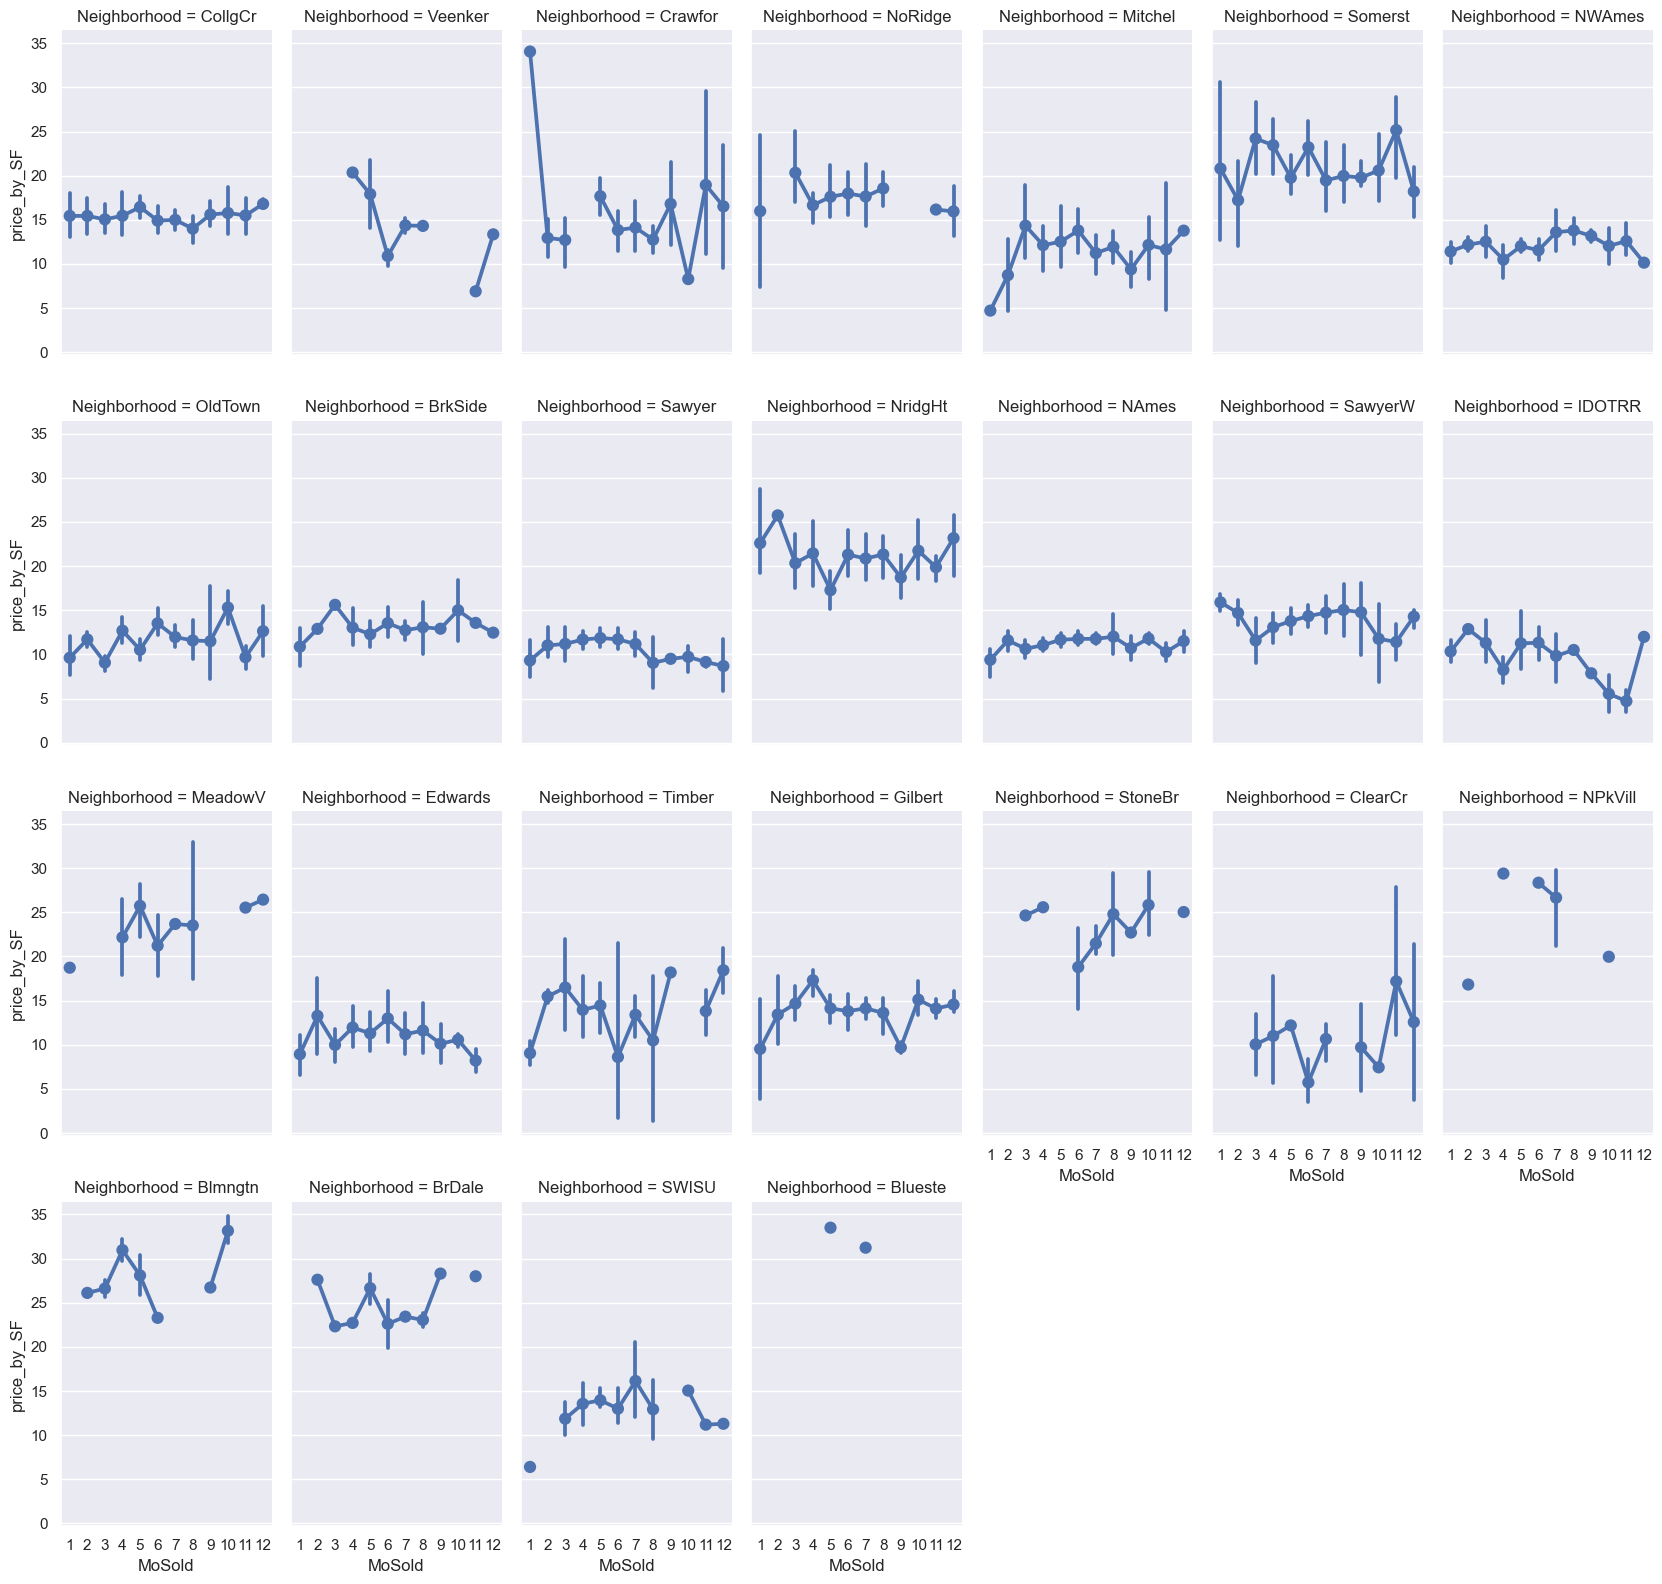

In [19]:
#according to ATTOM, even seasonality influences the selling price of an estate. We can try 
#to relate the season with Neighborhood and the total area. We can firstly define a new dataframe
#with the total areas of estates as follows (myneig=month+year+neighbours)
myneig = house[['SalePrice', 'MoSold', 'YrSold', 'Neighborhood']]
myneig['SFtot'] = (house.TotalBsmtSF.fillna(0) + house.WoodDeckSF.fillna(0) + house.GrLivArea.fillna(0) + 
                   house.LotArea.fillna(0) + house.MasVnrArea.fillna(0) + house.GarageArea.fillna(0) + 
                   house.OpenPorchSF.fillna(0) + house['3SsnPorch'].fillna(0) + house.ScreenPorch.fillna(0) + 
                   house.EnclosedPorch.fillna(0) + house.PoolArea.fillna(0))
#FIRST OVERLOOK TO OUR DATAS: WE UNDERSTAND THAT SOMETHING IS MISSING
myneig['price_by_SF'] = myneig.SalePrice / myneig.SFtot
fig = sns.catplot(y= 'price_by_SF', x = 'MoSold', col='Neighborhood', data=myneig, kind="point", aspect=.6, col_wrap=7, height=4)
plt.show()

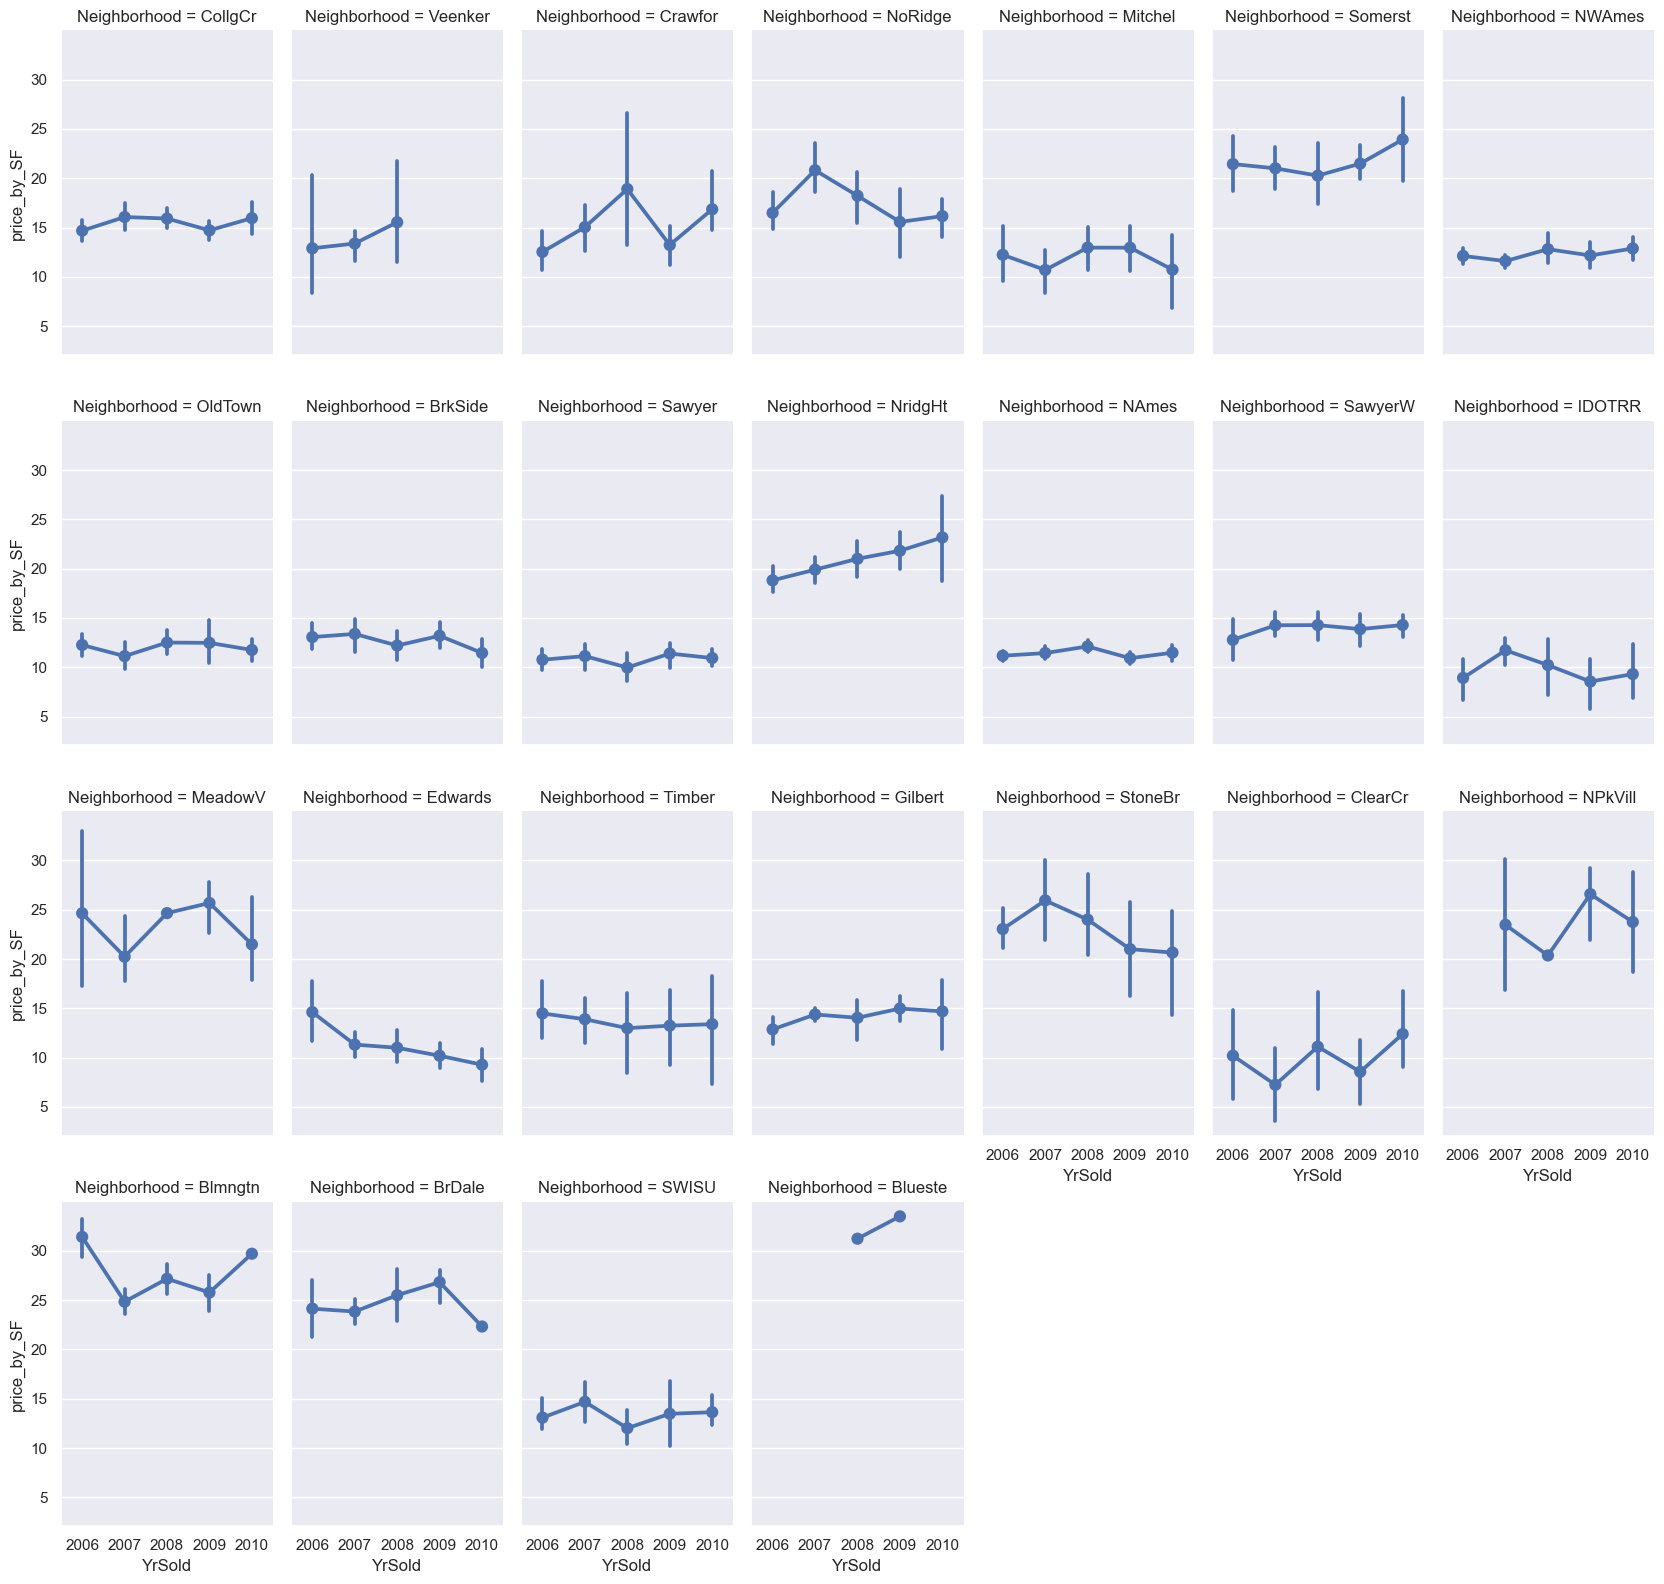

In [20]:
fig2 = sns.catplot(y= 'price_by_SF', x = 'YrSold', col='Neighborhood', data=myneig, kind="point", aspect=.6, col_wrap=7, height=4)
plt.show()

In [21]:
yneig = house[['SalePrice', 'YrSold', 'Neighborhood']]
yneig['SFtot'] = (house.TotalBsmtSF.fillna(0) + house.WoodDeckSF.fillna(0) + house.GrLivArea.fillna(0) + 
                   house.LotArea.fillna(0) + house.MasVnrArea.fillna(0) + house.GarageArea.fillna(0) + 
                   house.OpenPorchSF.fillna(0) + house['3SsnPorch'].fillna(0) + house.ScreenPorch.fillna(0) + 
                   house.EnclosedPorch.fillna(0) + house.PoolArea.fillna(0))
yneig = yneig.groupby(by=['Neighborhood', 'YrSold'], as_index=False).sum()
yneig['price_by_SF'] = yneig.SalePrice / yneig.SFtot
yneig.drop(['SFtot', 'SalePrice'], axis=1, inplace=True)


In [22]:
#we can better describe datas by filling gaps and store them in into new dataframes
# Fill the gaps

yneig = yneig.append(pd.DataFrame([['NPkVill', 2006, yneig.price_by_SF[yneig.Neighborhood=='NPkVill'].mean()]], columns=yneig.columns))

yneig = yneig.append(pd.DataFrame([['Veenker', 2009, yneig.price_by_SF[yneig.Neighborhood=='Veenker'].mean()]], columns=yneig.columns))

yneig = yneig.append(pd.DataFrame([['Veenker', 2010, yneig.price_by_SF[yneig.Neighborhood=='Veenker'].mean()]], columns=yneig.columns))

yneig = yneig.append(pd.DataFrame([['Blueste', 2006, yneig.price_by_SF[yneig.Neighborhood=='Blueste'].min()]], columns=yneig.columns))

yneig = yneig.append(pd.DataFrame([['Blueste', 2007, yneig.price_by_SF[yneig.Neighborhood=='Blueste'].min()]], columns=yneig.columns))

yneig = yneig.append(pd.DataFrame([['Blueste', 2010, yneig.price_by_SF[yneig.Neighborhood=='Blueste'].max()]], columns=yneig.columns))

Price_for_year = yneig
Price_for_year.columns = ['Neighborhood', 'YrSold', 'YearlyPriceByNeighborhood']


In [23]:
mneig= house[['SalePrice', 'MoSold', 'Neighborhood']]
mneig['SFtot'] = (house.TotalBsmtSF.fillna(0) + house.WoodDeckSF.fillna(0) + house.GrLivArea.fillna(0) + 
                   house.LotArea.fillna(0) + house.MasVnrArea.fillna(0) + house.GarageArea.fillna(0) + 
                   house.OpenPorchSF.fillna(0) + house['3SsnPorch'].fillna(0) + house.ScreenPorch.fillna(0) + 
                   house.EnclosedPorch.fillna(0) + house.PoolArea.fillna(0))
mneig = mneig.groupby(by=['Neighborhood', 'MoSold'], as_index=False).sum()
mneig['price_by_SF'] = mneig.SalePrice / mneig.SFtot
mneig.drop(['SFtot', 'SalePrice'], axis=1, inplace=True)


In [24]:
Neigb = {}
Neigb['Blueste'] = 'Top'     
Neigb['Blmngtn'] = 'Top'     
Neigb['BrDale']  = 'BrDale'  
Neigb['NPkVill'] = 'NPkVill' 
Neigb['MeadowV'] = 'High'    
Neigb['StoneBr'] = 'High'    
Neigb['NridgHt'] = 'High'    
Neigb['Somerst'] = 'Somerst' 
Neigb['NoRidge'] = 'NoRidge'
Neigb['CollgCr'] = 'CollgCr' 
Neigb['SawyerW'] = 'GS'      
Neigb['Gilbert'] = 'GS'      
Neigb['Crawfor'] = 'Crawfor' 
Neigb['BrkSide'] = 'BSVN'    
Neigb['SWISU']   = 'BSVN'    
Neigb['Veenker'] = 'BSVN'   
Neigb['NWAmes']  = 'BSVN'    
Neigb['OldTown'] = 'OldTown' 
Neigb['NAmes']   = 'NAmes'   
Neigb['Mitchel'] = 'Mitchel' 
Neigb['Edwards'] = 'Edwards' 
Neigb['Sawyer']  = 'Sawyer'  
Neigb['IDOTRR']  = 'IDOTRR'  
Neigb['Timber']  = 'Timber'  
Neigb['ClearCr'] = 'ClearCr' 
mneig.Neighborhood = mneig.Neighborhood.map(Neigb)


In [25]:
mneig = mneig.append(pd.DataFrame([['Top', 1, mneig.price_by_SF[mneig.Neighborhood=='Top'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['Top', 8, mneig.price_by_SF[mneig.Neighborhood=='Top'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['Top', 11, mneig.price_by_SF[mneig.Neighborhood=='Top'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['Top', 12, mneig.price_by_SF[mneig.Neighborhood=='Top'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['BrDale', 1, mneig.price_by_SF[mneig.Neighborhood=='BrDale'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['BrDale', 10, mneig.price_by_SF[mneig.Neighborhood=='BrDale'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['BrDale', 12, mneig.price_by_SF[mneig.Neighborhood=='BrDale'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NPkVill', 1, mneig.price_by_SF[mneig.Neighborhood=='NPkVill'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NPkVill', 3, mneig.price_by_SF[mneig.Neighborhood=='NPkVill'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NPkVill', 5, mneig.price_by_SF[mneig.Neighborhood=='NPkVill'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NPkVill', 8, mneig.price_by_SF[mneig.Neighborhood=='NPkVill'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NPkVill', 9, mneig.price_by_SF[mneig.Neighborhood=='NPkVill'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NPkVill', 11, mneig.price_by_SF[mneig.Neighborhood=='NPkVill'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NPkVill', 12, mneig.price_by_SF[mneig.Neighborhood=='NPkVill'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NoRidge', 2, mneig.price_by_SF[mneig.Neighborhood=='NoRidge'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NoRidge', 9, mneig.price_by_SF[mneig.Neighborhood=='NoRidge'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['NoRidge', 10, mneig.price_by_SF[mneig.Neighborhood=='NoRidge'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['Crawfor', 1, mneig.price_by_SF[mneig.Neighborhood=='Crawfor'].max()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['Crawfor', 4, mneig.price_by_SF[mneig.Neighborhood=='Crawfor'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['Timber', 10, mneig.price_by_SF[mneig.Neighborhood=='Timber'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['ClearCr', 1, mneig.price_by_SF[mneig.Neighborhood=='ClearCr'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['ClearCr', 2, mneig.price_by_SF[mneig.Neighborhood=='ClearCr'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['ClearCr', 8, mneig.price_by_SF[mneig.Neighborhood=='ClearCr'].mean()]], 
                            columns=mneig.columns))
mneig = mneig.append(pd.DataFrame([['Edwards', 12, mneig.price_by_SF[mneig.Neighborhood=='Edwards'].mean()]], 
                            columns=mneig.columns))

MonthlyPrice = mneig
MonthlyPrice.columns = ['Neigb', 'MoSold', 'MonthlyPriceByNeighborhood']


Corr with outliers LotArea_times_Slope/SalePrice: 0.39766551476403555
Corr LandSlope/SalePrice: -0.05169717157895433
Corr LotArea/SalePrice: 0.2696930346365782


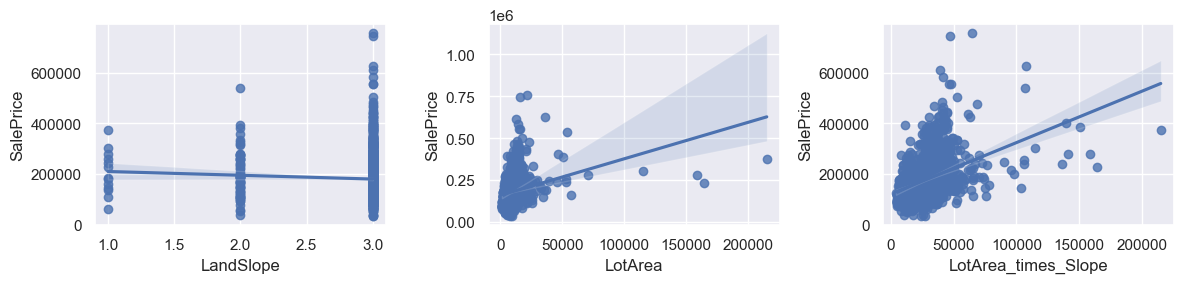

In [26]:
#LandSlope: Slope of property
LandSlope = {}
LandSlope['Gtl'] = 3 #'Gentle'
LandSlope['Mod'] = 2 #'Moderate'
LandSlope['Sev'] = 1 #'Severe'

slope = house[['SalePrice', 'LandSlope', 'LotArea']]
slope.LandSlope = slope.LandSlope.map(LandSlope)
slope['LotArea_times_Slope'] = (slope.LotArea * slope.LandSlope)

fig = plt.figure(figsize = (12, 3))
fig1 = fig.add_subplot(131);
sns.regplot(x = slope.LandSlope, y = slope.SalePrice, data = slope)

fig2 = fig.add_subplot(132);
sns.regplot(x = slope.LotArea, y = slope.SalePrice, data = slope)

fig3 = fig.add_subplot(133);
sns.regplot(x = slope.LotArea_times_Slope, y = slope.SalePrice, data = slope)

print('Corr with outliers LotArea_times_Slope/SalePrice:', slope.LotArea_times_Slope.corr(slope['SalePrice']))
print('Corr LandSlope/SalePrice:', slope.LandSlope.corr(slope['SalePrice']))
print('Corr LotArea/SalePrice:', slope.LotArea.corr(slope['SalePrice']))
plt.tight_layout()


In [27]:
# Funzione che fa il check dei nulli e richiama la funzione precendente
ntrain = house.shape[0]
ntest = house.shape[0]
y_train = house.SalePrice.values
all_data = pd.concat((house, test)).reset_index(drop=True)

print("All data observations have {0} rows and {1} columns".format(all_data.shape[0], all_data.shape[1]))
details = rstr(all_data)
print("All data have {1:2.2%} of null at {0} features".format(details[details.nulls>0].shape[0], details.nulls[details.nulls>0].sum()/all_data.size))
print('\nBelow the table with all columns with nulls oredered by missin ration:')
display(details.sort_values(by= 'miss_ratio', ascending=False))


All data observations have 2915 rows and 80 columns
Data shape:  (2915, 80)
----------Data types:  object     43
int64      34
float64     3
Name: types, dtype: int64
--------------------
All data have 5.96% of null at 19 features

Below the table with all columns with nulls oredered by missin ration:


,types,counts,uniques,nulls,miss_ratio,skew,curtosi
PoolQC,object,13,"[nan, Ex, Fa, Gd]",2902,99.554031,NaN,NaN
MiscFeature,object,107,"[nan, Shed, Gar2, Othr, TenC]",2808,96.329331,NaN,NaN
Alley,object,182,"[nan, Grvl, Pave]",2733,93.756432,NaN,NaN
Fence,object,562,"[nan, MnPrv, GdWo, GdPrv, MnWw]",2353,80.720412,NaN,NaN
FireplaceQu,object,1536,"[nan, TA, Gd, Fa, Ex, Po]",1379,47.307033,NaN,NaN
LotFrontage,float64,2398,"[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan...",517,17.735849,1.881264,14.848039
GarageYrBlt,float64,2753,"[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993....",162,5.557461,-0.647652,-0.421755
GarageCond,object,2753,"[TA, Fa, nan, Gd, Po, Ex]",162,5.557461,NaN,NaN
GarageType,object,2753,"[Attchd, Detchd, BuiltIn, CarPort, nan, Basmen...",162,5.557461,NaN,NaN
GarageFinish,object,2753,"[RFn, Unf, Fin, nan]",162,5.557461,NaN,NaN


In [28]:
feat = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars']
print(all_data[feat].isnull().sum())
print("GarageArea equal a 0: ", (all_data.GarageArea==0).sum())
print("GarageCars equal a 0: ", (all_data.GarageCars==0).sum())
c = all_data[~all_data.GarageType.isnull()][feat]
c[c.GarageYrBlt.isnull()]


GarageYrBlt     162
GarageType      162
GarageFinish    162
GarageQual      162
GarageCond      162
GarageArea        0
GarageCars        0
dtype: int64
GarageArea equal a 0:  162
GarageCars equal a 0:  162


,GarageYrBlt,GarageType,GarageFinish,GarageQual,GarageCond,GarageArea,GarageCars


In [29]:

all_data.GarageType = all_data.GarageType.fillna('NA')
# Group by GarageType and fill missing value with median where GarageType=='Detchd' and 0 for the others
cmedian = all_data[all_data.GarageType=='Detchd'].GarageArea.median()
print("GarageArea median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageArea'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageArea'].fillna(cmedian)
all_data.GarageArea = all_data.GarageArea.fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageCars.median()
print("GarageCars median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageCars'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCars'].fillna(cmedian)
all_data.GarageCars = all_data.GarageCars.fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageYrBlt.median()
print("GarageYrBlt median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageYrBlt'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                          'GarageYrBlt'].fillna(cmedian)
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(0)

# Group by GarageType and fill missing value with mode where GarageType=='Detchd' and 'NA' for the others
cmode = all_data[all_data.GarageType=='Detchd'].GarageFinish.mode()[0]
print("GarageFinish mode of Type Detchd:", cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageFinish'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                           'GarageFinish'].fillna(cmode)
all_data.GarageFinish = all_data.GarageFinish.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageQual.mode()[0]
print("GarageQual mode of Type Detchd: %s" %cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageQual'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageQual'].fillna(cmode)
all_data.GarageQual = all_data.GarageQual.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageCond.mode()[0]
print("GarageCond mode of Type Detchd:", cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageCond'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCond'].fillna(cmode)
all_data.GarageCond = all_data.GarageCond.fillna('NA')



GarageArea median of Type Detchd: 400.0
GarageCars median of Type Detchd: 2.0
GarageYrBlt median of Type Detchd: 1965.0
GarageFinish mode of Type Detchd: Unf
GarageQual mode of Type Detchd: TA
GarageCond mode of Type Detchd: TA


In [30]:
print(all_data[feat].isnull().sum())


GarageYrBlt     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
GarageArea      0
GarageCars      0
dtype: int64


In [31]:
#Eseguiamo il check dei nulli per MasVnrArea e MasVnrType
feat = ['MasVnrArea', 'MasVnrType']
c = all_data[~all_data.MasVnrArea.isnull()][feat]
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')
print("Has MasVnrType but not has MasVnrArea:",all_data[~all_data.MasVnrType.isnull()].MasVnrArea.isnull().sum())
print("Has MasVnrArea but not has MasVnrType:",c[c.MasVnrType.isnull()].MasVnrArea.count())
print(c[c.MasVnrType.isnull()], '\n')
#Vediamo se la casa ha MasVnrArea uguale a zero
print("Has MasVnrType but MasVnrArea is equal a Zero:",c[c.MasVnrArea==0].MasVnrType.count())
print("MasVnrArea equal a 0: ", (all_data.MasVnrArea==0).sum(), '\n')
print("Has Type and Area = 0:")
print(c[c.MasVnrArea==0].MasVnrType.value_counts(), '\n')

print("Type None with Area > 0 ?")
print(all_data.loc[(all_data.MasVnrType=='None') & (all_data.MasVnrArea>0), ['MasVnrType','MasVnrArea']])
#Vediamo qual è il più comune MasVnrType
print('\n What is the most comumn MasVnrType after None?')
print(all_data.MasVnrType.value_counts())


Masonry veneer Nulls:
MasVnrArea    16
MasVnrType    16
dtype: int64 

Has MasVnrType but not has MasVnrArea: 0
Has MasVnrArea but not has MasVnrType: 0
Empty DataFrame
Columns: [MasVnrArea, MasVnrType]
Index: [] 

Has MasVnrType but MasVnrArea is equal a Zero: 1721
MasVnrArea equal a 0:  1721 

Has Type and Area = 0:
None       1717
BrkFace       2
Stone         2
Name: MasVnrType, dtype: int64 

Type None with Area > 0 ?
     MasVnrType  MasVnrArea
622        None       288.0
771        None         1.0
1226       None         1.0
1295       None       344.0
1329       None       312.0
2079       None       288.0
2228       None         1.0
2685       None         1.0
2755       None       344.0
2789       None       312.0

 What is the most comumn MasVnrType after None?
None       1727
BrkFace     889
Stone       253
BrkCmn       30
Name: MasVnrType, dtype: int64


In [32]:
#Sostituiamo tutti i None Types con Area maggiore di 0 mettendo BrkFace type
all_data.loc[(all_data.MasVnrType=='None') & (all_data.MasVnrArea>0), ['MasVnrType']] = 'BrkFace'

#Sostituiamo tutti i null types con area maggiore di 0 mettendo BrkFace type
all_data.loc[(all_data.MasVnrType.isnull()) & (all_data.MasVnrArea>0), ['MasVnrType']] = 'BrkFace'

#Sostituiamo tutti i types diversi da None con area uguale a zero mettendo la mediana di area dei valori no None types con area
all_data.loc[(all_data.MasVnrType!='None') & (all_data.MasVnrArea==0), ['MasVnrArea']] = all_data.loc[(all_data.MasVnrType!='None') & (all_data.MasVnrArea>0), ['MasVnrArea']].median()[0]
# Riempiamo con 0 e None quando sono entrambi nulli
all_data.MasVnrArea = all_data.MasVnrArea.fillna(0)
all_data.MasVnrType = all_data.MasVnrType.fillna('None')


In [33]:
c = all_data[~all_data.MasVnrType.isnull()][feat]
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')


Masonry veneer Nulls:
MasVnrArea    0
MasVnrType    0
dtype: int64 



In [34]:
#Eseguiamo il check dei nulli
feat = ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
print(all_data[feat].isnull().sum())
#Vediamo quando ci sono valori uguali a zero
print("BsmtFinSF1 equal a 0: ", (all_data.BsmtFinSF1==0).sum())
print("BsmtFinSF2 equal a 0: ", (all_data.BsmtFinSF2==0).sum())
print("BsmtUnfSF equal a 0: ", (all_data.BsmtUnfSF==0).sum())
print("TotalBsmtSF equal a 0: ", (all_data.TotalBsmtSF==0).sum())
print("BsmtFullBath equal a 0: ", (all_data.BsmtFullBath==0).sum())
print("BsmtHalfBath equal a 0: ", (all_data.BsmtHalfBath==0).sum())


BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
BsmtFullBath     0
BsmtHalfBath     0
BsmtQual        74
BsmtCond        74
BsmtExposure    76
BsmtFinType1    74
BsmtFinType2    76
dtype: int64
BsmtFinSF1 equal a 0:  932
BsmtFinSF2 equal a 0:  2581
BsmtUnfSF equal a 0:  236
TotalBsmtSF equal a 0:  74
BsmtFullBath equal a 0:  1710
BsmtHalfBath equal a 0:  2751


In [35]:
# No Basement è il più comune BsmtExposure
display(all_data.BsmtExposure.value_counts())

# Sostituiamo i nulls Exposure con Av dove TotalBsmtSF è maggiore di zero
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & (all_data.BsmtExposure.isnull()) & (all_data.TotalBsmtSF>0), 'BsmtExposure'] = 'Av'


No    1904
Av     441
Gd     266
Mn     228
Name: BsmtExposure, dtype: int64

In [36]:
# TA è il più comune BsmtQual 
display(all_data.BsmtQual.value_counts())

# Sostituiamo TA per tutti i casi in cui sappiamo che la casa ha Basement
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & (all_data.BsmtQual.isnull()) & (all_data.TotalBsmtSF>0), 'BsmtQual'] = 'TA'


TA    1296
Gd    1236
Ex     239
Fa      70
Name: BsmtQual, dtype: int64

In [37]:
# Unf è il più comune BsmtFinType2. 
display(all_data.BsmtFinType2.value_counts())

# Sostituiamo Unf per tutti i casi dove BsmtFinType2 è nulla ma BsmtFinSF2 è maggiore di zero
all_data.loc[(all_data.BsmtFinSF2>0) & (all_data.BsmtFinType2.isnull()) , 'BsmtFinType2'] = 'Unf'


Unf    2507
Rec     108
LwQ      92
BLQ      66
ALQ      38
GLQ      28
Name: BsmtFinType2, dtype: int64

In [38]:
# Vediamo che abbiamo un caso dove BsmtFinType2 è BLQ e l'Area è zero, ma la sua area è stata sostituita da Unfinesh
display(all_data[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull())][feat])

# Sostituiamo BsmtFinSF2 e BsmtUnfSF:
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtFinSF2'] = 354.0
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtUnfSF'] = 0.0


,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2


In [39]:
# E' chiaro che tutti questi casi non hanno un Basement
print("Rest cases where Cond is Null", (all_data[all_data.BsmtCond.isnull()]).shape[0], '\n')
print('Others categories basement features are Null when Cond is Null:\n',
      (all_data[all_data.BsmtCond.isnull()][['BsmtQual', 'BsmtCond', 'BsmtExposure',
                                             'BsmtFinType1' , 'BsmtFinType2']]).isnull().sum())
print('\nOthers numerics basement features are Null or Zero when Cond is Null:\n',
      all_data[all_data.BsmtCond.isnull()][['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' ,'TotalBsmtSF',
                                            'BsmtFullBath', 'BsmtHalfBath']].sum())
print("\nThe particular cases where's numeric basement features see below are Null were included in the previous groups:") 
display(all_data[all_data.BsmtFullBath.isnull()][feat])

# Sostituiamo 0 e NA
nulls_cols = {'BsmtExposure': 'NA', 'BsmtFinType2': 'NA', 'BsmtQual': 'NA', 'BsmtCond': 'NA', 'BsmtFinType1': 'NA',
              'BsmtFinSF1': 0, 'BsmtFinSF2': 0, 'BsmtUnfSF': 0 ,'TotalBsmtSF': 0, 'BsmtFullBath': 0, 'BsmtHalfBath': 0}

all_data = all_data.fillna(value=nulls_cols)

print('\nFinal Check if all nulls basement features are treated:', all_data[feat].isnull().sum().sum())


Rest cases where Cond is Null 74 

Others categories basement features are Null when Cond is Null:
 BsmtQual        74
BsmtCond        74
BsmtExposure    74
BsmtFinType1    74
BsmtFinType2    74
dtype: int64

Others numerics basement features are Null or Zero when Cond is Null:
 BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

The particular cases where's numeric basement features see below are Null were included in the previous groups:


,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2



Final Check if all nulls basement features are treated: 0


In [40]:
PoolQC = {0: 'NA', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

all_data.loc[(all_data.PoolArea>0) & (all_data.PoolQC.isnull()), ['PoolQC']] =        ((all_data.loc[(all_data.PoolArea>0) & (all_data.PoolQC.isnull()), ['OverallQual']]/2).round()).        apply(lambda x: x.map(PoolQC))

all_data.PoolQC = all_data.PoolQC.fillna('NA')


In [41]:
all_data.Functional = all_data.Functional.fillna('Typ')
all_data.Alley = all_data.Alley.fillna('NA')
all_data.Fence = all_data.Fence.fillna('NA')
all_data.MiscFeature = all_data.MiscFeature.fillna('NA')
all_data.loc[(all_data.KitchenAbvGr>0) & (all_data.KitchenQual.isnull()), ['KitchenQual']] = all_data.KitchenQual.mode()[0]
all_data.loc[(all_data.Fireplaces==0) & (all_data.FireplaceQu.isnull()), ['FireplaceQu']] = 'NA'


In [42]:
#ExterQual: exterior material quality
#ExterCond: present condition of the material on the exterior (they are mapped in the same way)
#HeatingQC: heating quality and conditions
#KitchenQual: kitchen quality
#FireplaceQu: fireplace quality
#GarageCond: garage conditions

ExterQual = {}
ExterQual['Ex'] = 5 #excellent
ExterQual['Gd'] = 4 #good
ExterQual['TA'] = 3 #tipical/average
ExterQual['Fa'] = 2 #fair
ExterQual['Po'] = 1 #poor
ExterQual['NA'] = 0 #NA

all_data.ExterQual = all_data.ExterQual.map(ExterQual)
all_data.ExterCond = all_data.ExterCond.map(ExterQual)
all_data.HeatingQC = all_data.HeatingQC.map(ExterQual)
all_data.KitchenQual = all_data.KitchenQual.map(ExterQual)
all_data.FireplaceQu = all_data.FireplaceQu.map(ExterQual)
all_data.GarageCond = all_data.GarageCond.map(ExterQual)

#------------------------------------------
#PavedDrive: is the drivaway paved?
PavedDrive = {}
PavedDrive['Y'] = 3 #totally paved
PavedDrive['P'] = 2 #partially paved
PavedDrive['N'] = 1 #not paved or broken
all_data.PavedDrive = all_data.PavedDrive.map(PavedDrive)

#-------------------------------------------
#LotShape: general shape of the property
LotShape = {}
LotShape['Reg'] = 4 #regular
LotShape['IR1'] = 3 #slightly irregular
LotShape['IR2'] = 2 #moderately irregular
LotShape['IR3'] = 1 #irregular

all_data.LotShape = all_data.LotShape.map(LotShape)

#--------------------------------------------
#GarageFinish: interior finsih of the garage
GarageFinish = {}
GarageFinish['Fin'] = 3 #finished
GarageFinish['RFn'] = 2 #roughly finished
GarageFinish['Unf'] = 1 #unfinished
GarageFinish['NA'] = 0 #no garage at all

all_data.GarageFinish = all_data.GarageFinish.map(GarageFinish)

#--------------------------------------------
#BsmtExposure: walkout or garden level basement walls
BsmtExposure = {}
BsmtExposure['Gd'] = 4 #good exposure
BsmtExposure['Av'] = 3 #average exposure 
BsmtExposure['Mn'] = 2 #minimum exposure
BsmtExposure['No'] = 1 #no exposure
BsmtExposure['NA'] = 0 #no basement at all

all_data.BsmtExposure = all_data.BsmtExposure.map(BsmtExposure)

#---------------------------------------------
#BsmtQual: height of the basement
#PoolQC: pool quality
#BsmtCond: basement conditions
#GarageQual: garage quality

BsmtQual = {}
BsmtQual['Ex'] = 5 #excellent(>2.51mt)
BsmtQual['Gd'] = 4 #good(2.26/2.51mt)
BsmtQual['TA'] = 3 #typical(2/2.26mt)
BsmtQual['Fa'] = 2 #fair(1.8/2mt)
BsmtQual['Po'] = 1 #poor(<1.8mt)
BsmtQual['NA'] = 0 #No basement at all

all_data.BsmtQual = all_data.BsmtQual.map(BsmtQual)
all_data.BsmtCond = all_data.BsmtCond.map(BsmtQual) 
all_data.GarageQual = all_data.GarageQual.map(BsmtQual)
all_data.PoolQC = all_data.PoolQC.map(BsmtQual) 

#----------------------------------------------
#LandSlope: slope of the property
LandSlope = {}
LandSlope['Gtl'] = 3 #gentle slope
LandSlope['Mod'] = 2 #moderate slope
LandSlope['Sev'] = 1 #severe slope

all_data.LandSlope = all_data.LandSlope.map(LandSlope)

#-----------------------------------------------
#CentralAir: central air conditioning (binarization)

CentralAir = {}
CentralAir['Y'] = 1
CentralAir['N'] = 0

all_data.CentralAir = all_data.CentralAir.map(CentralAir)

#------------------------------------------------
#BsmtFinType1: quality of basement finished area
#BsmtFinType2: quality of secondo finished area, if present. same criteria of first one

BsmtFinType1 = {}
BsmtFinType1['GLQ'] = 6 #good living quarters
BsmtFinType1['ALQ'] = 5 #average [...]
BsmtFinType1['BLQ'] = 4 #below average [...]
BsmtFinType1['Rec'] = 3 #average rec room
BsmtFinType1['LwQ'] = 2 #low quality
BsmtFinType1['Unf'] = 1 #unfinished
BsmtFinType1['NA'] = 0 #no basement at all

all_data.BsmtFinType1 = all_data.BsmtFinType1.map(BsmtFinType1)
all_data.BsmtFinType2 = all_data.BsmtFinType2.map(BsmtFinType1)
 
#-------------------------------------------------
#Functional: home functionality rating

Functional = {}
Functional['Typ'] = 7   # typical Functionality
Functional['Min1'] = 6  # minor Deductions 1
Functional['Min2'] = 5  # minor Deductions 2
Functional['Mod'] = 4   # moderate Deductions
Functional['Maj1'] = 3  # major Deductions 1
Functional['Maj2'] = 2  # major Deductions 2
Functional['Sev'] = 1   # severely Damaged
Functional['Sal'] = 0   # salvage only

all_data.Functional = all_data.Functional.map(Functional)

#--------------------------------------------------
#Fence: Fence quality
Fence = {}
Fence['GdPrv'] = 5 #good privacy
Fence['MnPrv'] = 4 #minimum privacy
Fence['GdWo'] = 3 #good wood
Fence['MnWw'] = 2 #minimum wood/wire
Fence['NA'] = 1 #no fence at all

all_data.Fence = all_data.Fence.map(Fence)


In [43]:

# # Group by Neigborhood and fill missing value with Lot frontage median of the respect Neigborhood
# NegMean = all_data.groupby('Neighborhood').LotFrontage.mean()
# all_data.loc.LotFrontage = all_data[['Neighborhood', 'LotFrontage']].\
#                            apply(lambda x: NegMean[x.Neighborhood] if np.isnan(x.LotFrontage) else x.LotFrontage, axis=1)
mean = all_data['LotFrontage'].mean()
all_data['LotFrontage'] = np.where(np.isnan(all_data['LotFrontage']), mean, all_data['LotFrontage'])



In [44]:
#since we have already dealt with correlations between different features, 
#we can now define the same features in the dataframe that we will use in the modeling phase 

all_data['Tot_baths_bsmt'] = all_data.FullBath + (all_data.HalfBath*0.5) + all_data.BsmtFullBath + (all_data.BsmtHalfBath*0.5)
all_data.FullBath = all_data.FullBath.apply(lambda x: 1 if x else 0)
all_data.HalfBath = all_data.HalfBath.apply(lambda x: 1 if x else 0)
all_data.BsmtFullBath = all_data.BsmtFullBath.apply(lambda x: 1 if x else 0)
all_data.BsmtHalfBath = all_data.BsmtHalfBath.apply(lambda x: 1 if x else 0)

all_data['LotArea_times_Slope'] = all_data.LotArea * all_data.LandSlope
all_data['Total_Porch'] = all_data.OpenPorchSF + all_data.EnclosedPorch + all_data['3SsnPorch'] + all_data.ScreenPorch + all_data.WoodDeckSF
all_data.EnclosedPorch = all_data.EnclosedPorch.apply(lambda x: 1 if x else 0)
all_data['house_times_gar'] = all_data.YearBuilt * all_data.GarageYrBlt

all_data['TotalBsmtSF_x_Bsm'] = all_data.TotalBsmtSF * all_data['1stFlrSF']
all_data['GArea_times_Car'] = all_data.GarageArea * all_data.GarageCars

all_data.MSSubClass = all_data.MSSubClass.astype('str')
all_data.MoSold = all_data.MoSold.astype('str')


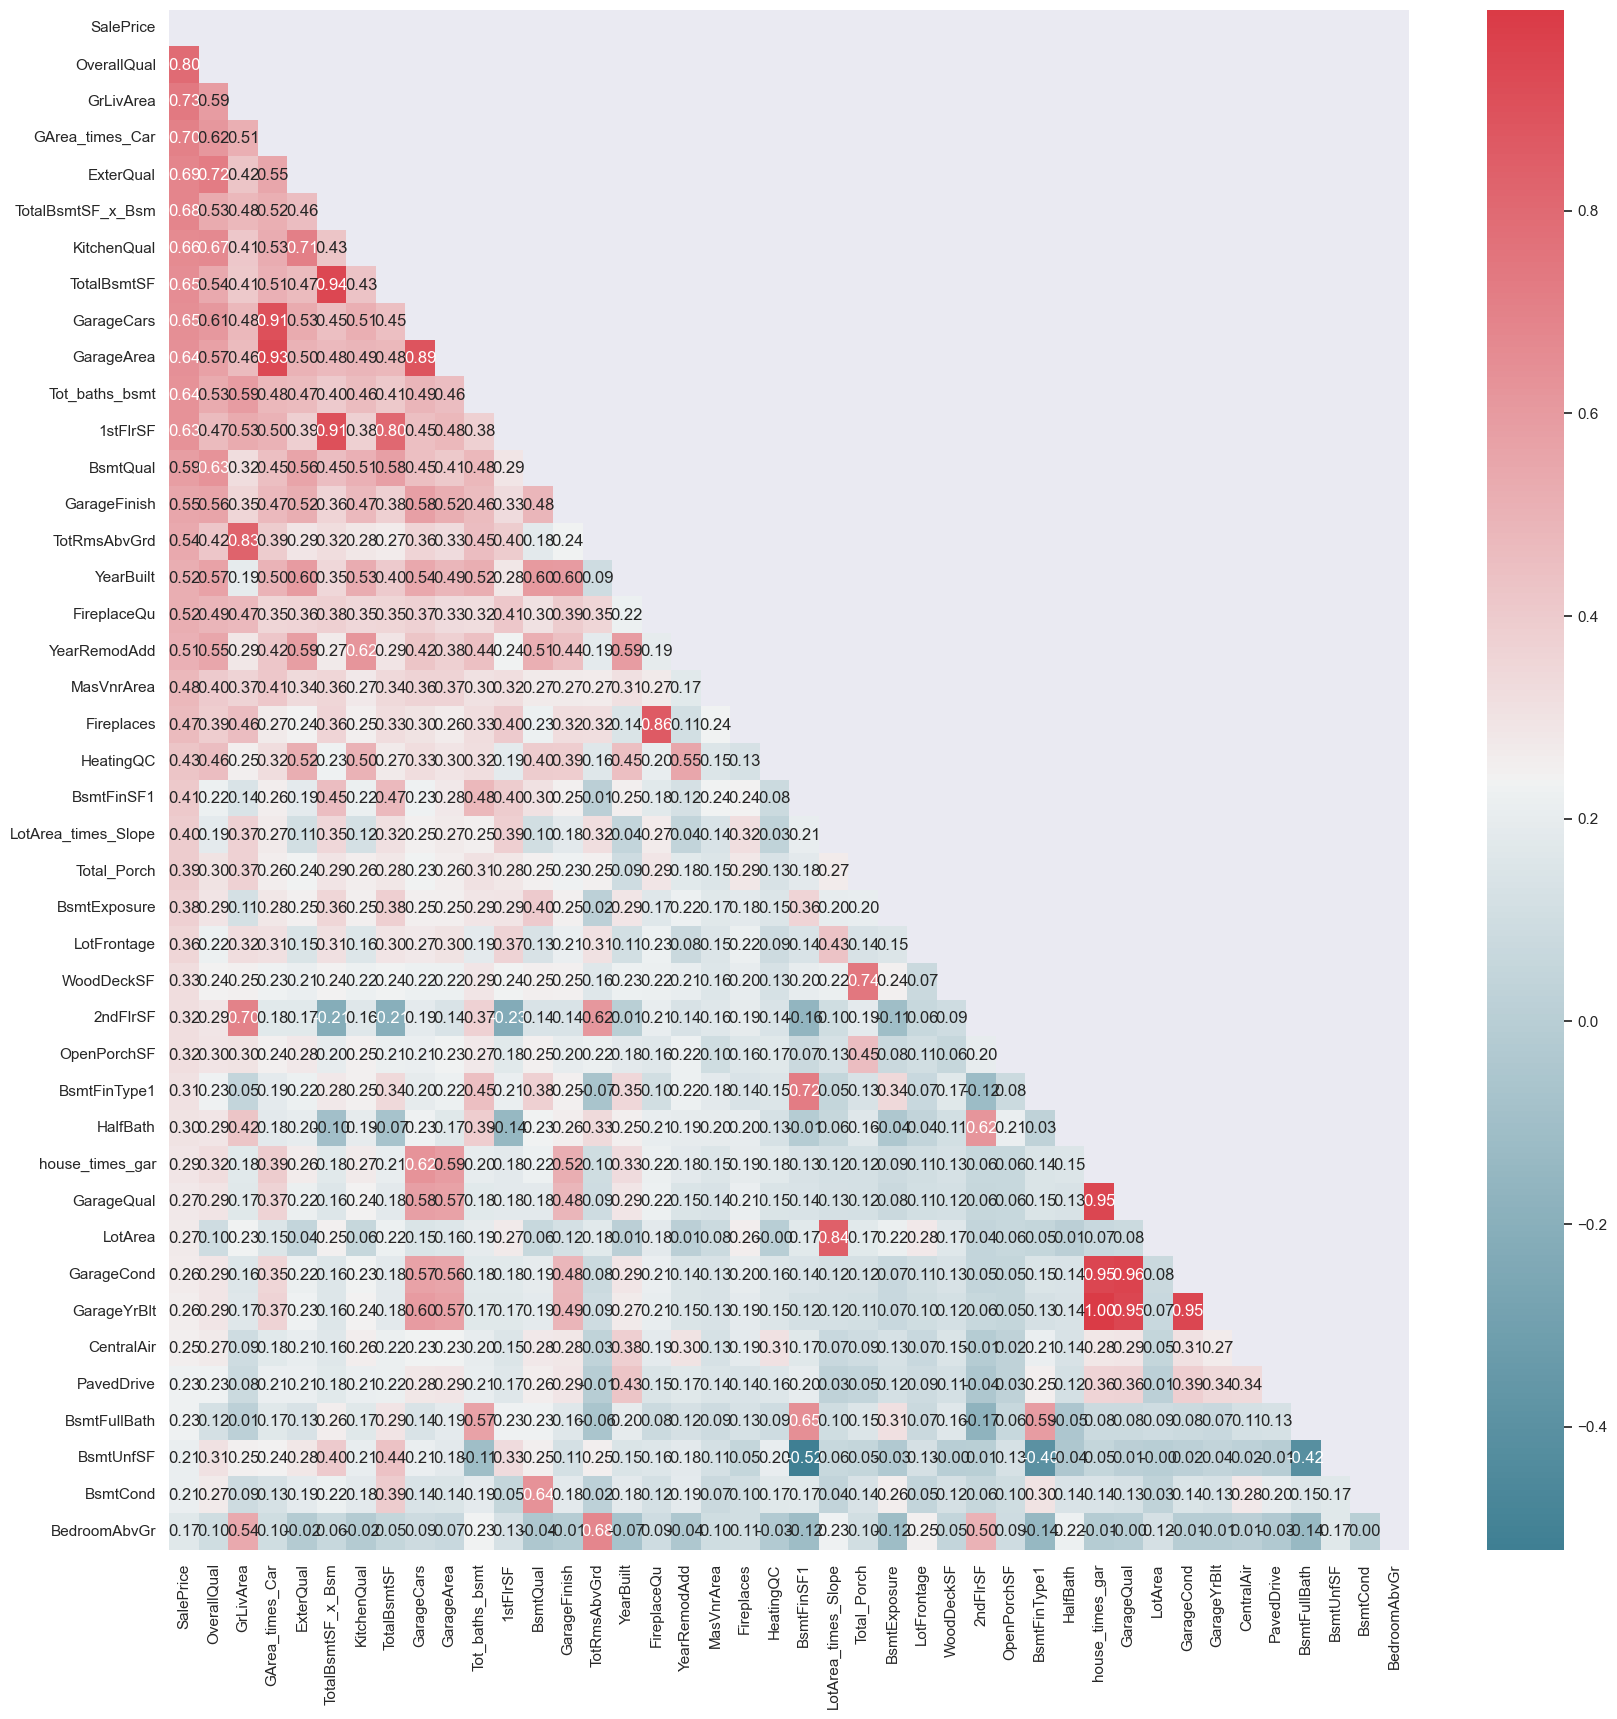

In [45]:
corr = all_data[all_data.SalePrice>1].corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.16)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.5)
plt.show()
del corr, dropSelf, top_corr


In [46]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge


In [47]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [48]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Tot_baths_bsmt,LotArea_times_Slope,Total_Porch,house_times_gar,TotalBsmtSF_x_Bsm,GArea_times_Car
0,60,RL,65.0,8450,Pave,NA,4,Lvl,AllPub,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,1,SBrkr,856,854,0,1710,1,0,1,1,3,1,4,8,7,0,0,Attchd,2003.0,2,2,548,3,3,3,0,61,0,0,0,0,0,1,NA,0,2,2008,WD,Normal,208500,3.5,25350,61,4012009.0,732736,1096
1,20,RL,80.0,9600,Pave,NA,4,Lvl,AllPub,FR2,3,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,1,SBrkr,1262,0,0,1262,0,1,1,0,3,1,3,6,7,1,3,Attchd,1976.0,2,2,460,3,3,3,298,0,0,0,0,0,0,1,NA,0,5,2007,WD,Normal,181500,2.5,28800,298,3904576.0,1592644,920
2,60,RL,68.0,11250,Pave,NA,3,Lvl,AllPub,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,1,SBrkr,920,866,0,1786,1,0,1,1,3,1,4,6,7,1,3,Attchd,2001.0,2,2,608,3,3,3,0,42,0,0,0,0,0,1,NA,0,9,2008,WD,Normal,223500,3.5,33750,42,4004001.0,846400,1216
3,70,RL,60.0,9550,Pave,NA,3,Lvl,AllPub,Corner,3,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,7,1,4,Detchd,1998.0,1,3,642,3,3,3,0,35,1,0,0,0,0,1,NA,0,2,2006,WD,Abnorml,140000,2.0,28650,307,3826170.0,726516,1926
4,60,RL,84.0,14260,Pave,NA,3,Lvl,AllPub,FR2,3,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,1,SBrkr,1145,1053,0,2198,1,0,1,1,4,1,4,9,7,1,3,Attchd,2000.0,2,3,836,3,3,3,192,84,0,0,0,0,0,1,NA,0,12,2008,WD,Normal,250000,3.5,42780,276,4000000.0,1311025,2508


In [49]:
all_data.MSSubClass = all_data.MSSubClass.astype('str')
all_data.MoSold = all_data.MoSold.astype('str')


In [50]:
def one_hot_encode(df):
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(len(categorical_cols), "categorical columns")
    print(categorical_cols)
    # Remove special charactres and withe spaces. 
    for col in categorical_cols:
        df[col] = df[col].str.replace('\W', '').str.replace(' ', '_') #.str.lower()

    dummies = pd.get_dummies(df[categorical_cols], columns = categorical_cols).columns
    df = pd.get_dummies(df, columns = categorical_cols)

    print("Total Columns:",len(df.columns))
    print(df.info())
    
    return df, dummies

all_data, dummies = one_hot_encode(all_data)


25 categorical columns
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType',
       'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')
Total Columns: 257
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Columns: 257 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(5), int64(56), uint8(196)
memory usage: 1.9 MB
None


In [51]:
ZeroTest = all_data[dummies][ntrain:].sum()==0
all_data.drop(dummies[ZeroTest], axis=1, inplace=True)
dummies = dummies.drop(dummies[ZeroTest])

ZeroTest = all_data[dummies][:ntrain].sum()==0
all_data.drop(dummies[ZeroTest], axis=1, inplace=True)
dummies = dummies.drop(dummies[ZeroTest])
del ZeroTest


In [52]:
for feat in all_data.columns:
    if all_data[feat].dtype=='uint8':
        all_data[feat] = all_data[feat].astype('category')

In [53]:
from sklearn.model_selection import train_test_split


In [54]:
cols = all_data.columns
len(cols)

256

In [55]:
train = all_data.loc[(all_data.SalePrice>0), cols].reset_index(drop=True, inplace=False)
y_train = (all_data.SalePrice[all_data.SalePrice>0].reset_index(drop=True, inplace=False))

In [56]:
scale = RobustScaler()
df = pd.DataFrame(scale.fit_transform(train[cols]), columns= cols)

In [57]:
# mdm = train.max().max()
# print(mdm)

In [58]:
y_scaled = df['SalePrice']

In [59]:
train.head()

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,YrSold,SalePrice,Tot_baths_bsmt,LotArea_times_Slope,Total_Porch,house_times_gar,TotalBsmtSF_x_Bsm,GArea_times_Car,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_Call,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_15Fin,HouseStyle_15Unf,HouseStyle_1Story,HouseStyle_25Fin,HouseStyle_25Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_TarGrv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_WdSdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkCmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_WdSdng,Exterior2nd_WdShng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,4,3,7,5,2003,2003,196.0,4,3,4,3,1,6,706,1,0,150,856,5,1,85

In [60]:
y_train.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [61]:
#df['SalePrice']

In [62]:
df2 = train.drop('SalePrice', axis = 1)
cols2 = df2.columns


In [63]:
import statsmodels.api as sm


In [64]:
# ln_model=sm.OLS(y_train,df)
# ln_model=sm.OLS(y_scaled, df)
# result=ln_model.fit()
# print(result.summary2())


ln_model=sm.OLS(y_train,df)
result=ln_model.fit()
print(result.summary2())


                               Results: Ordinary least squares
Model:                        OLS                      Adj. R-squared:             1.000      
Dependent Variable:           SalePrice                AIC:                        -50007.3647
Date:                         2023-09-27 19:12         BIC:                        -48797.6124
No. Observations:             1455                     Log-Likelihood:             25233.     
Df Model:                     228                      F-statistic:                6.710e+26  
Df Residuals:                 1226                     Prob (F-statistic):         0.00       
R-squared:                    1.000                    Scale:                      6.0088e-17 
----------------------------------------------------------------------------------------------
                         Coef.    Std.Err.          t           P>|t|     [0.025      0.975]  
----------------------------------------------------------------------------------

In [65]:
print(type(train))
print(type(y_train))

# print(len(train))
# print(len(y_train))

print((train.shape))
print((y_train.shape))



# print(train.columns)
# print(y_train.columns)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(1455, 256)
(1455,)


In [66]:
pv_cols = cols.values

def backwardElimination(x, Y, sl, columns):
    ini = len(columns)
    numVars = x.shape[1]
    for i in range(0, numVars):
        regressor = sm.OLS(Y, x).fit()
        maxVar = max(regressor.pvalues) #.astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor.pvalues[j].astype(float) == maxVar):
                    columns = np.delete(columns, j)
                    x = x.loc[:, columns]
                    
    print('\nSelect {:d} features from {:d} by best p-values.'.format(len(columns), ini))
    print('The max p-value from the features selecte is {:.3f}.'.format(maxVar))
    print(regressor.summary())
    
    # odds ratios and 95% CI
    conf = np.exp(regressor.conf_int())
    conf['Odds Ratios'] = np.exp(regressor.params)
    conf.columns = ['2.5%', '97.5%', 'Odds Ratios']
    display(conf)
    return columns, regressor

SL = 0.051

pv_cols, LR = backwardElimination(df, y_train, SL, pv_cols)




Select 116 features from 256 by best p-values.
The max p-value from the features selecte is 0.000.
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.014e+27
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        19:13:26   Log-Likelihood:                 24892.
No. Observations:                1455   AIC:                        -4.957e+04
Df Residuals:                    1350   BIC:                        -4.902e+04
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------

,2.5%,97.5%,Odds Ratios
YearBuilt,1.000000e+00,1.000000e+00,1.000000e+00
YearRemodAdd,1.000000e+00,1.000000e+00,1.000000e+00
ExterCond,1.000000e+00,1.000000e+00,1.000000e+00
BsmtFinSF1,inf,inf,inf
BsmtFinSF2,2.770830e+11,2.770830e+11,2.770830e+11
BsmtUnfSF,inf,inf,inf
TotalBsmtSF,0.000000e+00,0.000000e+00,0.000000e+00
1stFlrSF,inf,inf,inf
2ndFlrSF,inf,inf,inf
LowQualFinSF,2.505221e+29,2.505221e+29,2.505221e+29


In [67]:
print(y_train,y_scaled)


0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
30       40000
31      149350
32      179900
33      165500
34      277500
35      309000
36      145000
37      153000
38      109000
39       82000
40      160000
41      170000
42      144000
43      130250
44      141000
45      319900
46      239686
47      249700
48      113000
49      127000
50      177000
51      114500
52      110000
53      385000
54      130000
55      180500
56      172500
57      196500
58      438780
59      124900
60      158000
61      101000
62      202500
63      140000
64      219500
65      317000
66      18

In [68]:
len(pv_cols)


116

In [69]:
array_colonne = df.columns.to_numpy()
elementi_unici = np.setxor1d(array_colonne, pv_cols)


In [70]:
df2.shape
df2.head()

,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,YrSold,Tot_baths_bsmt,LotArea_times_Slope,Total_Porch,house_times_gar,TotalBsmtSF_x_Bsm,GArea_times_Car,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_Call,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NA,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_15Fin,HouseStyle_15Unf,HouseStyle_1Story,HouseStyle_25Fin,HouseStyle_25Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_TarGrv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_WdSdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkCmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_WdSdng,Exterior2nd_WdShng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,4,3,7,5,2003,2003,196.0,4,3,4,3,1,6,706,1,0,150,856,5,1,856,854,0,17

In [71]:
condizione = df.corr()['SalePrice'] > 0
colonne_selezionate = df.loc[:, condizione]
print(colonne_selezionate.columns.tolist())


['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'SalePrice', 'Tot_baths_bsmt', 'LotArea_times_Slope', 'Total_Porch', 'house_times_gar', 'TotalBsmtSF_x_Bsm', 'GArea_times_Car', 'MSSubClass_120', 'MSSubClass_20', 'MSSubClass_60', 'MSSubClass_75', 'MSZoning_FV', 'MSZoning_RL', 'Street_Pave', 'Alley_NA', 'LandContour_HLS', 'LandContour_Low', 'Utilities_AllPub', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR3', 'Neighborhood_Blmngtn', 'Neighborhood_ClearCr',

In [72]:
df3 = colonne_selezionate
df3 = df3.drop('SalePrice', axis = 1)


In [73]:
cols3 = colonne_selezionate.columns
len(cols3)


129

In [74]:
df3.shape

# print(df3.head())

(1455, 128)

In [75]:
dataframe = df3.to_numpy()
colonne = df3.columns.to_numpy() 

In [76]:
dataframe

array([[-0.25742944, -0.25155048,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53204425,  0.03373853,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0995347 ,  0.44306624,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.20479786, -0.10468866,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0995347 ,  0.06276358, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26888635,  0.11734061, -0.5       , ...,  0.        ,
         0.        ,  0.        ]])

In [77]:
colonne

array(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Tot_baths_bsmt',
       'LotArea_times_Slope', 'Total_Porch', 'house_times_gar',
       'TotalBsmtSF_x_Bsm', 'GArea_times_Car', 'MSSubClass_120',
       'MSSubClass_20', 'MSSubClass_60', 'MSSubClass_75', 'MSZoning_FV',
       'MSZoning_RL', 'Street_Pave', 'Alley_NA', 'LandContour_HLS',
       'LandContour_Low', 'Utilities_AllPub', 'LotConfig_Cor

In [78]:
# ls = Lasso(alpha = 0.0005, max_iter = 161, selection = 'cyclic', tol = 0.002, random_state = 101)
# rfecv = RFECV(estimator=ls, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' , cv=5)
# rfecv.fit(df3, y_scaled)

# select_features_rfecv = rfecv.get_support()

In [79]:
ls = Lasso(alpha = 0.0005, max_iter = 161, selection = 'cyclic', tol = 0.002, random_state = 101)
rfecv = RFECV(estimator=ls, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' , cv=5)
rfecv.fit(dataframe, y_train)

select_features_rfecv = rfecv.get_support()

In [80]:
len(select_features_rfecv)

128

In [81]:
len(colonne)

128

In [82]:
RFEcv = colonne[select_features_rfecv]

In [83]:
RFEcv

array(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'ExterQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageCars', 'GarageArea', 'GarageQual', 'PoolQC',
       'LotArea_times_Slope', 'TotalBsmtSF_x_Bsm', 'GArea_times_Car',
       'MSSubClass_120', 'MSSubClass_20', 'MSSubClass_60',
       'MSSubClass_75', 'MSZoning_FV', 'Street_Pave', 'LandContour_HLS',
       'LandContour_Low', 'Utilities_AllPub', 'LotConfig_CulDSac',
       'LotConfig_FR3', 'Neighborhood_Blmngtn', 'Neighborhood_Crawfor',
       'Neighborhood_Gilbert', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_Norm',
       'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAn',
       'Condition1_RRNn',

In [84]:
len(RFEcv)

89

In [85]:
from sklearn.model_selection import train_test_split
import numpy as np

In [86]:
#now we can define the last dataframe, RFEcv_df, such that 
colonne_def_rfe = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'ExterQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageCars', 'GarageArea', 'GarageQual', 'PoolQC',
       'LotArea_times_Slope', 'TotalBsmtSF_x_Bsm', 'GArea_times_Car',
       'MSSubClass_120', 'MSSubClass_20', 'MSSubClass_60',
       'MSSubClass_75', 'MSZoning_FV', 'Street_Pave', 'LandContour_HLS',
       'LandContour_Low', 'Utilities_AllPub', 'LotConfig_CulDSac',
       'LotConfig_FR3', 'Neighborhood_Blmngtn', 'Neighborhood_Crawfor',
       'Neighborhood_Gilbert', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_Norm',
       'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAn',
       'Condition1_RRNn', 'Condition2_Norm', 'Condition2_PosA',
       'Condition2_PosN', 'Condition2_RRAe', 'BldgType_1Fam',
       'HouseStyle_25Fin', 'HouseStyle_2Story', 'RoofStyle_Flat',
       'RoofStyle_Hip', 'RoofStyle_Shed', 'RoofMatl_Membran',
       'RoofMatl_TarGrv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior1st_BrkFace', 'Exterior1st_CemntBd',
       'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior1st_VinylSd',
       'Exterior2nd_BrkFace', 'Exterior2nd_ImStucc', 'Exterior2nd_Other',
       'Exterior2nd_VinylSd', 'MasVnrType_BrkFace', 'Foundation_Wood',
       'GarageType_Attchd', 'MiscFeature_NA', 'MiscFeature_TenC',
       'MoSold_1', 'MoSold_11', 'MoSold_12', 'MoSold_8', 'SaleType_CWD',
       'SaleType_Con', 'SaleType_ConLI', 'SaleType_New',
       'SaleCondition_Partial']

In [87]:
RFEcv_df = df[colonne_def_rfe]

In [88]:
df_y_train = pd.DataFrame(y_train)
df_y_train.head()

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


In [89]:
limiti_fasce = [0, 150000, 300000, np.inf]
etichette_fasce = ['Low', 'Medium', 'High']
df_y_train['Price_tag']  = pd.cut(df_y_train['SalePrice'], bins = limiti_fasce, labels = etichette_fasce, right = False)
#df['Price_tag']  = pd.cut(df['SalePrice'].values, bins = (0, 150000, 300000, float('inf')), labels = ('Low', 'Medium', 'High'), right = False)

In [90]:
df_y_train.head()

,SalePrice,Price_tag
0,208500,Medium
1,181500,Medium
2,223500,Medium
3,140000,Low
4,250000,Medium


In [91]:
# df['SalePrice'].head()
#df3 = df3.drop('SalePrice', axis = 1)

In [92]:
df_y_train2 = df_y_train["Price_tag"]
df_y_train2

# print(df_y_train)
# print(df_y_train2)

0       Medium
1       Medium
2       Medium
3          Low
4       Medium
5          Low
6         High
7       Medium
8          Low
9          Low
10         Low
11        High
12         Low
13      Medium
14      Medium
15         Low
16         Low
17         Low
18      Medium
19         Low
20        High
21         Low
22      Medium
23         Low
24      Medium
25      Medium
26         Low
27        High
28      Medium
29         Low
30         Low
31         Low
32      Medium
33      Medium
34      Medium
35        High
36         Low
37      Medium
38         Low
39         Low
40      Medium
41      Medium
42         Low
43         Low
44         Low
45        High
46      Medium
47      Medium
48         Low
49         Low
50      Medium
51         Low
52         Low
53        High
54         Low
55      Medium
56      Medium
57      Medium
58        High
59         Low
60      Medium
61         Low
62      Medium
63         Low
64      Medium
65        High
66      Me

In [93]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [94]:
seed = 101
models = []
models.append(('C45', DecisionTreeClassifier(criterion='entropy', random_state=seed)))
models.append(('CART', DecisionTreeClassifier(criterion='gini', random_state=seed)))
models.append(('GaussianNaiveBayes', GaussianNB()))
models.append(('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=2000, verbose=False, random_state=seed)))

In [95]:
def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='YlOrBr', title=None):
    group_counts = [f'{value}\n' for value in cf.flatten()]

    box_labels = [f'{v1}'.strip() for v1 in group_counts]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    sns.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    if title:
        plt.title(title)

In [96]:
x = np.array(RFEcv_df.values)
y = np.array(df_y_train2.values)
scaler = StandardScaler()

test_size = .3
val_size = .2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, random_state=seed)

kf = KFold(n_splits=5, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(x_train):
    x_train_fold, x_val_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    scaler.fit(x_train_fold)
    x_train_scaled = scaler.transform(x_train_fold)
    x_val_scaled = scaler.transform(x_val_fold)
    
    for name, model in models[:2]:
        # Train the model on the scaled training set
        estimator = model.fit(x_train_scaled, y_train_fold)

        # Evaluate the model on the scaled validation set
        y_val_pred = estimator.predict(x_val_scaled)

        # Print the classification metrics for the evaluated model
        print('Classification metrics for model', name, ':')
        print(classification_report(y_val_fold, y_val_pred))
        
#     for name, model in models[:2]:  # Utilizza solo i primi due modelli (C45 e CART)
#         categories = ['Low', 'Medium', 'High']
#         # Train the model on the scaled training set
#         estimator = model.fit(x_train_scaled, y_train_fold)

#         # Evaluate the model on the scaled validation set
#         y_val_pred = estimator.predict(x_val_scaled)

#         # Calculate the confusion matrix
#         print('Confusion matrix for model', name, ':')
#         make_confusion_matrix(confusion_matrix(y_val_fold, y_val_pred), categories=categories, cmap='Blues')
#         #confusion = confusion_matrix(y_val_fold, y_val_pred)
#         # Print the confusion matrix for the evaluated model
        
#         print(confusion)

Classification metrics for model C45 :
              precision    recall  f1-score   support

        High       0.59      0.71      0.65        14
         Low       0.81      0.90      0.85        86
      Medium       0.86      0.76      0.81       104

    accuracy                           0.81       204
   macro avg       0.75      0.79      0.77       204
weighted avg       0.82      0.81      0.81       204

Classification metrics for model CART :
              precision    recall  f1-score   support

        High       0.79      0.79      0.79        14
         Low       0.81      0.91      0.86        86
      Medium       0.88      0.80      0.84       104

    accuracy                           0.84       204
   macro avg       0.83      0.83      0.83       204
weighted avg       0.85      0.84      0.84       204

Classification metrics for model C45 :
              precision    recall  f1-score   support

        High       0.69      0.79      0.73        14
         Lo

In [97]:
i = 0
for train_index, test_index in kf.split(x_train):
    x_train_fold, x_val_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    scaler.fit(x_train_fold)
    x_train_scaled = scaler.transform(x_train_fold)
    x_val_scaled = scaler.transform(x_val_fold)
    
    print("Numero: ",i)
    
    for name, model in models[2:]:
        # Train the model on the scaled training set
        estimator = model.fit(x_train_scaled, y_train_fold)

        # Evaluate the model on the scaled validation set
        y_val_pred = estimator.predict(x_val_scaled)

        # Print the classification metrics for the evaluated model
        print('Classification metrics for model', name, ':')
        print(classification_report(y_val_fold, y_val_pred))
    i=i+1

Numero:  0
Classification metrics for model GaussianNaiveBayes :
              precision    recall  f1-score   support

        High       0.17      0.79      0.27        14
         Low       0.67      0.99      0.80        86
      Medium       0.73      0.08      0.14       104

    accuracy                           0.51       204
   macro avg       0.52      0.62      0.40       204
weighted avg       0.66      0.51      0.43       204

Classification metrics for model NeuralNetwork :
              precision    recall  f1-score   support

        High       0.75      0.86      0.80        14
         Low       0.87      0.95      0.91        86
      Medium       0.94      0.85      0.89       104

    accuracy                           0.89       204
   macro avg       0.85      0.89      0.87       204
weighted avg       0.90      0.89      0.89       204

Numero:  1
Classification metrics for model GaussianNaiveBayes :
              precision    recall  f1-score   support

    

In [98]:
# evaluation phase: facciamo predizioni sul test set
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [99]:
results = []
probs = []
models = []
models.append(('C45', DecisionTreeClassifier(criterion='entropy', random_state=seed)))
models.append(('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=2000, verbose=False, random_state=seed)))
# mlp_model = MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=2000, verbose=False, random_state=seed)
for train_index, test_index in kf.split(x_train):
    x_train_fold, x_val_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    scaler.fit(x_train_fold)
    x_train_scaled = scaler.transform(x_train_fold)
    x_val_scaled = scaler.transform(x_val_fold)
    
    for name, model in models:
        
#         mlp_model.fit(x_train_scaled, y_train_fold)
#         y_val_pred = mlp_model.predict(x_val_scaled)
#         results.append(classification_report(y_val_fold, y_val_pred))
        model.fit(x_train_scaled, y_train_fold)
        y_val_pred = model.predict(x_val_scaled)
        results.append(classification_report(y_val_fold, y_val_pred))
    
scaler.fit(x_train)
x_test_scaled = scaler.transform(x_test)

for name, model in models:
#     y_test_pred = mlp_model.predict(x_test_scaled)
#     probs.append(mlp_model.predict_proba(x_test_scaled))
#     print('Classification metrics for MLP model on the test set:')
#     print(classification_report(y_test, y_test_pred))
#     print(f'Accuracy: {accuracy_score(y_test, y_test_pred): 2f}')
    y_test_pred = model.predict(x_test_scaled)
    probs.append(model.predict_proba(x_test_scaled))
    print('Classification metrics for', name, 'model on the test set:')
    print(classification_report(y_test, y_test_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_test_pred): 2f}')

Classification metrics for C45 model on the test set:
              precision    recall  f1-score   support

        High       0.70      0.70      0.70        33
         Low       0.77      0.82      0.79       185
      Medium       0.79      0.75      0.77       219

    accuracy                           0.78       437
   macro avg       0.75      0.76      0.75       437
weighted avg       0.78      0.78      0.78       437

Accuracy:  0.775744
Classification metrics for NeuralNetwork model on the test set:
              precision    recall  f1-score   support

        High       0.77      0.52      0.62        33
         Low       0.83      0.88      0.86       185
      Medium       0.83      0.83      0.83       219

    accuracy                           0.83       437
   macro avg       0.81      0.74      0.77       437
weighted avg       0.82      0.83      0.82       437

Accuracy:  0.826087


In [100]:
# model = MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=2000, verbose=False, random_state=seed)
# model.fit(x_train, y_train)
# y_test_pred = model.predict(x_test_scaled)
# print(f'Accuracy: {accuracy_score(y_test, predictions): 2f}')

In [101]:
# # Transform the test set using the same scaler
# x_test_scaled = scaler.transform(x_test)

# # Apply the trained MLP model to the scaled test set
# y_test_pred = mlp_model.predict(x_test_scaled)

In [102]:
# def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='YlOrBr', title=None):
#     group_counts = [f'{value}\n' for value in cf.flatten()]

#     box_labels = [f'{v1}'.strip() for v1 in group_counts]
#     box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

#     sns.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
#     if title:
#         plt.title(title)

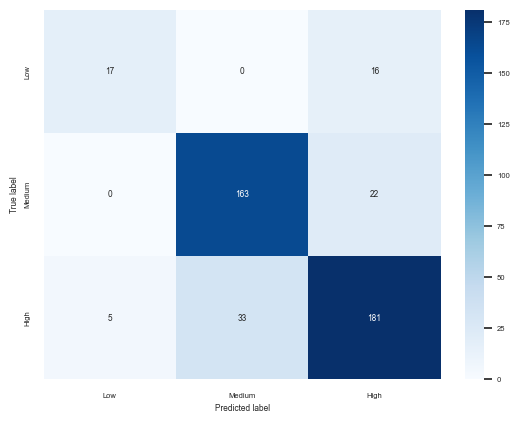

In [103]:
categories = ['Low', 'Medium', 'High']
make_confusion_matrix(confusion_matrix(y_test, y_test_pred), categories=categories, cmap='Blues')

In [104]:
from sklearn.metrics import roc_curve, auc

In [105]:
#DA QUA IN POI FINIRE

In [106]:
# for train_index, test_index in kf.split(x_train):
#     x_train_fold, x_val_fold = x_train[train_index], x_train[test_index]
#     y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

#     scaler.fit(x_train_fold)
#     x_train_scaled = scaler.transform(x_train_fold)
#     x_val_scaled = scaler.transform(x_val_fold)
    
#     for name, model in models    
#         model.fit(x_train_scaled, y_train_fold)
#         y_val_pred = model.predict(x_val_scaled)
#         results.append(classification_report(y_val_fold, y_val_pred))
    
# scaler.fit(x_train)
# x_test_scaled = scaler.transform(x_test)
# y_test_pred = model.predict(x_test_scaled)


In [107]:
# probs = []
# for _, model in models:
#     model.fit(x_train, y_train)
#     probs.append(model.predict_proba(x_test))

In [108]:
one_hot_encoding = np.array(pd.get_dummies(y_test, columns = df_y_train2))

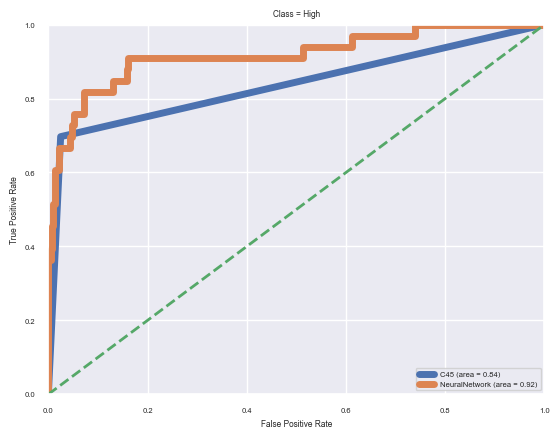

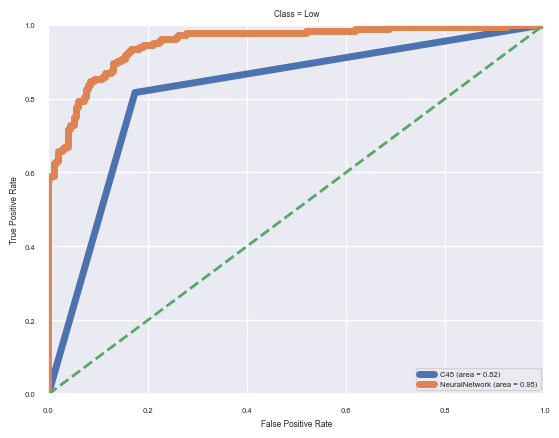

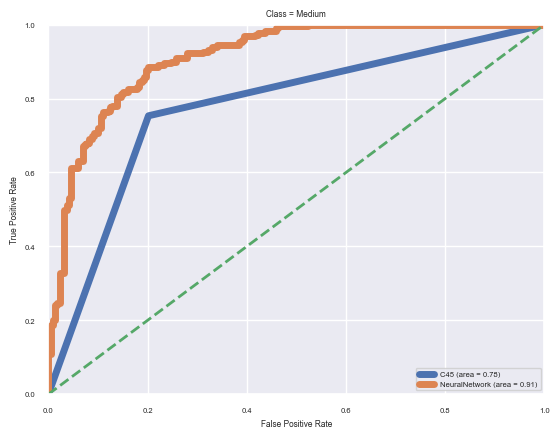

In [109]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    plt.figure()
    m = 0

    for name, _ in models:
        fpr[i], tpr[i], _ = roc_curve(one_hot_encoding[:, i], probs[m][:, i])
        
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=5, label=name + f' (area = {roc_auc[i]:.2f})')
        m += 1

    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class = ' + str(np.unique(y)[i]))
    plt.legend(loc='lower right')

    plt.show()  

In [110]:
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(len(np.unique(y))):
#     plt.figure()
#     m = 0

#     for name, _ in models:
#         fpr[i], tpr[i], _ = roc_curve(one_hot_encoding[:, i], probs[m][:, i])
        
#         print(one_hot_encoding[:, i])
#         print(probs[m][:, i])
        
#         roc_auc[i] = auc(fpr[i], tpr[i])

#         plt.plot(fpr[i], tpr[i], lw=5, label=name + f' (area = {roc_auc[i]:.2f})')
#         m += 1
        
#         if m==2:
#             break
#     break

In [111]:
# from sklearn.model_selection import learning_curve
# from sklearn.svm import SVC
# from sklearn.model_selection import ShuffleSplit

In [112]:
# models = []
# models.append(('C45', DecisionTreeClassifier(criterion='entropy', random_state=seed), 1))
# models.append(('CART', DecisionTreeClassifier(criterion='gini', random_state=seed), 2))
# models.append(('GaussianNaiveBayes', GaussianNB(),3))
# models.append(('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=2000, verbose=False, random_state=seed), 4))


# # for name, model in models:
# #     # Calculate the learning curves
# #     train_sizes, train_scores, test_scores = learning_curve(
# #         estimator, x_train, y_train, train_sizes=np.linspace(0.1, 1.0, 300), cv= 5, n_jobs = 4, scoring='accuracy', verbose = False)

# #     train_scores_mean = -train_scores.mean(axis = 1)
# #     test_scores_mean = -test_scores.mean(axis = 1)
# #     # Plot the learning curves
# #     plt.plot(train_sizes, train_scores, label='Training')
# #     plt.plot(train_sizes, test_scores, label='Validation')
# #     plt.title(name)
# #     #plt.legend()
# #     plt.show()

# def learning_curves(estimator, features, target, train_sizes, cv):
#     train_sizes, train_scores, test_scores = learning_curve(estimator, features, target, train_sizes = train_sizes,
#     cv = cv, scoring = 'accuracy')
#     train_scores_mean = train_scores.mean(axis = 1)
#     validation_scores_mean = test_scores.mean(axis = 1)

#     plt.plot(train_sizes, train_scores_mean, label = 'Training error')
#     plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

#     plt.ylabel('Accuracy', fontsize = 14)
#     plt.xlabel('Training set size', fontsize = 14)
#     title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
#     plt.title(title, fontsize = 18, y = 1.03)
#     plt.legend()
#     #plt.ylim(0,40)
    
# plt.figure(figsize = (16,8))    
# for name, model, i in models:
#     plt.tight_layout()
#     plt.subplot(2,2,i)
#     learning_curves(model, x_train, y_train, (0.1, 0.2, 0.5, 0.7, 0.9), 5)